#**Library**

In [1]:
pip install "git+https://github.com/FelSiq/DBCV"


  Cloning https://github.com/FelSiq/DBCV to /tmp/pip-req-build-_dkt4wcv
  Running command git clone --filter=blob:none --quiet https://github.com/FelSiq/DBCV /tmp/pip-req-build-_dkt4wcv
  Resolved https://github.com/FelSiq/DBCV to commit 13c3896ef78d12f1e3e1cbd394f2db9a09637ffd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dbcv: filename=dbcv-0.1.1-py3-none-any.whl size=6619 sha256=c3c4a860006b6526ab047dd1151a67922e53422aa4f6bf8fb7a2b1a15f38d7de
  Stored in directory: /tmp/pip-ephem-wheel-cache-l77elfvn/wheels/db/29/5c/22f8798fd788b7f37312b81a63fab3aa43bea8270f453fbe8c
Successfully built dbcv


In [2]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
import hdbscan
from hdbscan import HDBSCAN
import time
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from dbcv import dbcv
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score,adjusted_rand_score , davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.utils import resample
from scipy.stats import entropy
import math
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.utils import resample
import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.special import erf
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)



a.spagnolo9@campus.unimib.ii

#**Function**

In [4]:
def optimalK(data, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarray of shape (n_samples, n_features)
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    nrefs = 3
    gaps = np.zeros((len(range(1, maxClusters)),))
    results = []

    for gap_index, k in enumerate(range(1, maxClusters)):

        refDisps = np.zeros(nrefs)

        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(n_clusters=k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp
        km = KMeans(n_clusters=k)
        km.fit(data)

        origDisp = km.inertia_

        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        gaps[gap_index] = gap
        results.append({'clusterCount': k, 'gap': gap})
    resultsdf = pd.DataFrame(results)
    return gaps.argmax() + 1, resultsdf

In [5]:
def generate_moon_datasets(seed):
    datasets = []

    for noise in [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]:
        X, _ = make_moons(n_samples=1000, noise=noise, random_state=seed)
        datasets.append(X)

    return datasets

In [6]:
def plot_datasets(datasets):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i, dataset in enumerate(datasets):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.scatter(dataset[:, 0], dataset[:, 1], c='black', s=1)
        ax.set_title(f'Dataset {i+1}')
        ax.set_xlim(-1.5, 2.5)
        ax.set_ylim(-1.0, 1.5)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_best_results_compare(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        print(dataset_results)
        for min_samples_, epsilon_, dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz,shannon_entropy, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}\nsilhouette={silhouette:.3f}\ndunn={dunn_index:.3f}\ndavies={davies_bouldin:.3f}\ncalinski={calinski_harabasz:.3f}\nshannon_entropy={shannon_entropy:.3f}')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
#Se non funziona usare funzione precedente
def calculate_dunn_index(X, labels):

    X = np.array(X) if not isinstance(X, np.ndarray) else X
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return -1

    distances = np.sqrt(((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2).sum(axis=2))
    min_intercluster_distances = np.inf
    for label_i in unique_labels:
        cluster_i = X[labels == label_i]
        for label_j in unique_labels:
            if label_i != label_j:
                cluster_j = X[labels == label_j]
                intercluster_distances = np.min(distances[np.ix_(labels == label_i, labels == label_j)])
                min_intercluster_distances = min(min_intercluster_distances, intercluster_distances)
    max_intracluster_distances = 0
    for label in unique_labels:
        cluster = X[labels == label]
        intracluster_distances = np.max(distances[np.ix_(labels == label, labels == label)])
        max_intracluster_distances = max(max_intracluster_distances, intracluster_distances)
    return min_intercluster_distances / max_intracluster_distances



In [9]:
def analyze_datasets(datasets):
    results = []
    param_grid = {
        'min_samples': [10],
        'epsilon': [0.1]
    }

    for X in datasets:
        dataset_results = []
        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                #clusterer = hdbscan.HDBSCAN(min_samples = min_samples, cluster_selection_epsilon=epsilon)
                labels = clusterer.fit_predict(X)

                dbcv_score = dbcv(X, labels)
                silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
                dunn_index = calculate_dunn_index(X, labels)
                davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
                calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
                shannon_entropy = calculate_shannon_entropy(labels)
                dataset_results.append((min_samples, epsilon, dbcv_score, silhouette, dunn_index,
                                        davies_bouldin, calinski_harabasz, shannon_entropy, labels))

        results.append(dataset_results)

    return results

In [10]:
def analyze_datasets_best_params(datasets):
    results = []
    param_grid = {
        'min_samples': [1, 5, 10, 50],
        'epsilon': [0.01, 0.1, 0.2, 0.5]
    }

    for X in datasets:
        dataset_results = []

        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                labels = clusterer.fit_predict(X)
                dbcv_score = dbcv(X, labels)
                dataset_results.append((min_samples, epsilon, dbcv_score,labels))

        results.append(dataset_results)

    return results

In [11]:
def find_best_params(results):
    param_dbvcs = {}

    for dataset_results in results:
        for min_samples, epsilon, dbcv_score, labels in dataset_results:
            param_key = (min_samples, epsilon)
            if param_key not in param_dbvcs:
                param_dbvcs[param_key] = []
            param_dbvcs[param_key].append(dbcv_score)

    param_avg_dbcv = {k: np.mean(v) for k, v in param_dbvcs.items()}

    best_params = max(param_avg_dbcv, key=param_avg_dbcv.get)

    return best_params

In [12]:
import matplotlib.pyplot as plt

def plot_best_results(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params
    min_samples = 2
    epsilon = 0.1

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        for min_samples_, epsilon_, dbcv_score, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                if dbcv_score is not None:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}')
                else:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv=N/A')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
def calculate_shannon_entropy(labels):
    labels = np.array(labels) if not isinstance(labels, np.ndarray) else labels
    unique, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    # labels = labels + 1
    # entropy_val = entropy(np.bincount(labels) / len(labels), base=2)
    # entropy_val = abs(1-entropy_val)
    return entropy

In [14]:
def plot_datasets_with_clustering(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(18, 30))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = dataset

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(-1.5, 2.5)
        ax_left.set_ylim(-1.0, 1.5)
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(min_samples=10, eps=0.1)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(-1.5, 2.5)
        ax_middle.set_ylim(-1.0, 1.5)
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)


        #dbcv_score = dbcv(X, labels)
        dbcv_score= dbcv(X, labels, check_duplicates=False)
        dbcv_total.append(dbcv_score)
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)
        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)
        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        # Calcolo entropia e normalizzazione
        num_clusters = len(set(labels))
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)
        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)


        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score),4)}\n'
                        f'Silhouette: {round(float(silhouette),4)}\n'
                        f'Dunn Index: {round(float(dunn_index),4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm),4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz),4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm),4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total,gap_total


In [15]:
def generate_circle_data(n_points, radius, shift):
    t = np.linspace(0, 2 * np.pi, n_points)
    x = radius * np.cos(t) + shift[0]
    y = radius * np.sin(t) + shift[1]
    return np.column_stack((x, y))

In [16]:
def generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment):
    datasets = []
    for i in range(n_datasets):
        outer_circle = generate_circle_data(n_points_per_circle, outer_radius, (0, 0))

        shift = (initial_shift[0] + i * shift_increment[0], initial_shift[1] + i * shift_increment[1])
        inner_circle = generate_circle_data(n_points_per_circle_inner, inner_radius, shift)

        dataset = np.concatenate([outer_circle, inner_circle])
        datasets.append(dataset)
    return datasets


In [17]:
def plot_datasets_with_clustering_circle(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(30, 50))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = np.unique(dataset, axis=0)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_aspect('equal')
        ax_left.grid(True, color='lightgrey', linewidth=0.5)  # Griglia chiara e sottile

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(eps=0.1, min_samples=20)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(x_min, x_max)
        ax_middle.set_ylim(y_min, y_max)
        ax_middle.set_aspect('equal')
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)  # Griglia chiara e sottile

        # try:
        #     dbcv_score = dbcv(X, labels) #dbcv(X, labels,check_duplicates=False)
        # except ValueError:
        #     dbcv_score = DBCV(X, labels)
        dbcv_score= dbcv(X, labels, check_duplicates=False)
        dbcv_total.append(dbcv_score)

        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)
        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)

        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)

        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)

        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score),4)}\n'
                        f'Silhouette: {round(float(silhouette),4)}\n'
                        f'Dunn Index: {round(float(dunn_index),4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm),4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz),4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm),4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [18]:
def generate_noisy_circles(n_datasets, n_samples, noise_increment, seed):
    datasets = []
    for i in range(n_datasets):
        noise_level = 0.05 + i * noise_increment
        noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=noise_level, random_state=seed)
        datasets.append(noisy_circles[0])
    return datasets

In [19]:
def plot_datasets_with_clustering_noisy_circles(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(30, 50))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = np.unique(dataset, axis=0)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_aspect('equal')
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(eps=0.1, min_samples=10)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(x_min, x_max)
        ax_middle.set_ylim(y_min, y_max)
        ax_middle.set_aspect('equal')
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)

        # try:
        #     dbcv_score = dbcv(X, labels)
        # except ValueError:
        #     dbcv_score = DBCV(X, labels)
        dbcv_score= dbcv(X, labels, check_duplicates=False)
        dbcv_total.append(dbcv_score)

        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)

        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)

        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)

        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)

        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score), 4)}\n'
                        f'Silhouette: {round(float(silhouette), 4)}\n'
                        f'Dunn Index: {round(float(dunn_index), 4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm), 4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz), 4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm), 4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [20]:
def generate_augmented_datasets(seed):
    datasets = []
    noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

    for noise in noise_levels:
        np.random.seed(seed)
        num_new_points = 400
        new_points = normalized_points[np.random.choice(normalized_points.shape[0], num_new_points)]
        noisy_new_points = new_points + np.random.normal(0, noise, (num_new_points, 2))

        noisy_new_points = noisy_new_points % 1

        augmented_data = np.vstack((normalized_points, noisy_new_points))
        datasets.append(augmented_data)

    return datasets


In [21]:
def analyze_datasets_tulipan(datasets):
    results = []
    for X in datasets:
        dataset_results = []
        min_samples, epsilon = 35, 0.1
        clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
        labels = clusterer.fit_predict(X)

        #dbcv_score = DBCV(X, labels)
        dbcv_score = dbcv(X, labels,check_duplicates=False)
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        dunn_index = calculate_dunn_index(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin = 1 / davies_bouldin if davies_bouldin > 0 else -1
        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        num_clusters = len(set(labels))
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']


        dataset_results.append((dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz, shannon_entropy, optimal_gap_statistic, labels))
        results.append(dataset_results)

    return results

In [22]:
def plot_datasets_with_clustering_tulipan(datasets, results):
    fig, axes = plt.subplots(10, 3, figsize=(18, 30))
    dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total,gap_total = [], [], [], [], [], [], []

    for i, (dataset, metrics) in enumerate(zip(datasets, results)):
        X = dataset
        dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz, shannon_entropy, optimal_gap_statistic, labels = metrics[0]
        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(-0.1, 1.1)
        ax_left.set_ylim(-0.1, 1.1)
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(-0.1, 1.1)
        ax_middle.set_ylim(-0.1, 1.1)
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)

        ax_right = axes[i, 2]
        ax_right.axis('off')
        metrics_text = (f'DBCV: {round(dbcv_score, 4)}\n'
                        f'Silhouette: {round(silhouette, 4)}\n'
                        f'Dunn Index: {round(dunn_index, 4)}\n'
                        f'Davies-Bouldin (Rec): {round(1 / davies_bouldin if davies_bouldin > 0 else -1, 4)}\n'
                        f'Calinski-Harabasz: {round(calinski_harabasz, 4)}\n'
                        f'Entropy (Norm): {round(shannon_entropy, 4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')
        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

        dbcv_total.append(dbcv_score)
        silhouette_total.append(silhouette)
        dunn_total.append(dunn_index)
        davies_total.append(1 / davies_bouldin if davies_bouldin > 0 else -1)
        calinski_total.append(calinski_harabasz)
        entropy_total.append(shannon_entropy)
        gap_total.append(optimal_gap_statistic)

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [23]:
def best_params_hdbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        hdbscan_val = HDBSCAN(min_cluster_size=min_cluster_size,
                             cluster_selection_epsilon=epsilon)

        labels = hdbscan_val.fit_predict(df)

        if len(set(labels)) > 1:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels


  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")

  return best_params[0],best_params[1]

In [24]:
def best_params_dbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        dbscan_pca = DBSCAN(min_samples=min_cluster_size,
                             eps=epsilon)

        labels = dbscan_pca.fit_predict(df)

        if len(set(labels)) > 1:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels

  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")
  return best_params[0], best_params[1]

In [25]:
def best_params_mean_shift(df):
  bandwidth_estimate = estimate_bandwidth(df, quantile=0.2, n_samples=500)
  bandwidth_range = np.linspace(bandwidth_estimate * 0.5, bandwidth_estimate * 1.5, 10)
  best_bandwidth = None
  best_score = -np.inf

  for bandwidth in bandwidth_range:
    ms = MeanShift(bandwidth=bandwidth)
    labels = ms.fit_predict(df)

    if len(set(labels)) > 1:
        try:

            dbcv_score = dbcv(df, labels)
            if dbcv_score > best_score:
                best_score = dbcv_score
                best_bandwidth = bandwidth
        except ValueError as e:
            print(f"Errore calcolando DBCV per banda {round(bandwidth,3)}: {e}")
    else:
        print(f"Banda {bandwidth} genera solo un cluster. Ignorato.")

  print(f"Best bandwidth: {round(best_bandwidth,3)}")
  return best_bandwidth

In [26]:
def similar_cluster(df):
  valori_unici_ms = df["Mean_shift_pred"].unique()
  valori_unici_db = df["DBSCAN_pred"].unique()
  valori_unici_hdb = df["HDBSCAN_pred"].unique()
  print(valori_unici_ms)
  print(valori_unici_db)
  print(valori_unici_hdb)

  mean_shift_labels = valori_unici_ms
  dbscan_labels = valori_unici_db
  hdbscan_labels = valori_unici_hdb
  total_rows = len(df)

  result = []

  for mean_label in mean_shift_labels:
    for dbscan_label in dbscan_labels:
        for hdbscan_label in hdbscan_labels:

            mask = (df['Mean_shift_pred'] == mean_label) & \
                   (df['DBSCAN_pred'] == dbscan_label) & \
                   (df['HDBSCAN_pred'] == hdbscan_label)
            count = mask.sum()
            percentage = (count / total_rows) * 100
            result.append({
                'Mean_shift': mean_label,
                'DBSCAN': dbscan_label,
                'HDBSCAN': hdbscan_label,
                'Percentuale': percentage
            })
  result_df = pd.DataFrame(result)
  result_df = result_df.sort_values(by='Percentuale', ascending=False)
  return result_df
# MAssimo X abbinamenti perche cluster con meno label ha solo X cluster, quindi sicuramente non ci possono
# essere piu abbinamenti di X abbinamenti di cluster corretti. Sono stati selezionati quelli che hanno
# fornito una percentuale maggiore escludendo cluster gia selezionati


In [27]:
def compute_ari(df):
  ariAbs1 = abs(adjusted_rand_score(neuroblastoma_scaled["DBSCAN_pred"], neuroblastoma_scaled["HDBSCAN_pred"]))
  ariAbs2 = abs(adjusted_rand_score(neuroblastoma_scaled["HDBSCAN_pred"], neuroblastoma_scaled["Mean_shift_pred"]))
  ariAbs3 = abs(adjusted_rand_score(neuroblastoma_scaled["Mean_shift_pred"], neuroblastoma_scaled["DBSCAN_pred"]))

  ariAbsAverage = (ariAbs1 + ariAbs2 + ariAbs3) / 3
  return ariAbsAverage

In [28]:
def compute_metrics(X, labels):
  #dbcv_score = round((dbcv(X, labels)),2)
  dbcv_score= round(dbcv(X, labels, check_duplicates=False),2)
  silhouette = round((silhouette_score(X, labels) if len(set(labels)) > 1 else -1),2)
  dunn_index = calculate_dunn_index(X, labels)
  davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
  davies_bouldin_norm = round((1 / davies_bouldin if davies_bouldin > 0 else -1),2)
  calinski_harabasz = round((calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1),2)
  num_clusters = len(set(labels))
  entropy = calculate_shannon_entropy(labels)
  shannon_entropy_norm = round((abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1),2)
  n_clusters,gap_df = optimalK(X, 20)
  optimal_gap_statistic = round((gap_df.loc[gap_df.gap.idxmax(), 'gap']),2)

  return dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic

#**Find Best Params**

In [ ]:
# start_time = time.time()
# datasets = generate_moon_datasets()
# results = analyze_datasets_best_params(datasets)
# best_params = find_best_params(results)
# plot_best_results(datasets, results, best_params)
# end_time = time.time()

# print(f"Tempo totale di esecuzione: {end_time - start_time:.2f} secondi")


#**Artificial Datasets**

**Moons**

FASTDBCV --> errore duplicati.

punti con distanze euclidee dal loro vicino più prossimo inferiori a 1e-9 (10^-9) sono considerati duplicati.

Quindi non vengono rimossi da drop_duplicates, ma vengono considerati duplicati da DBCV.

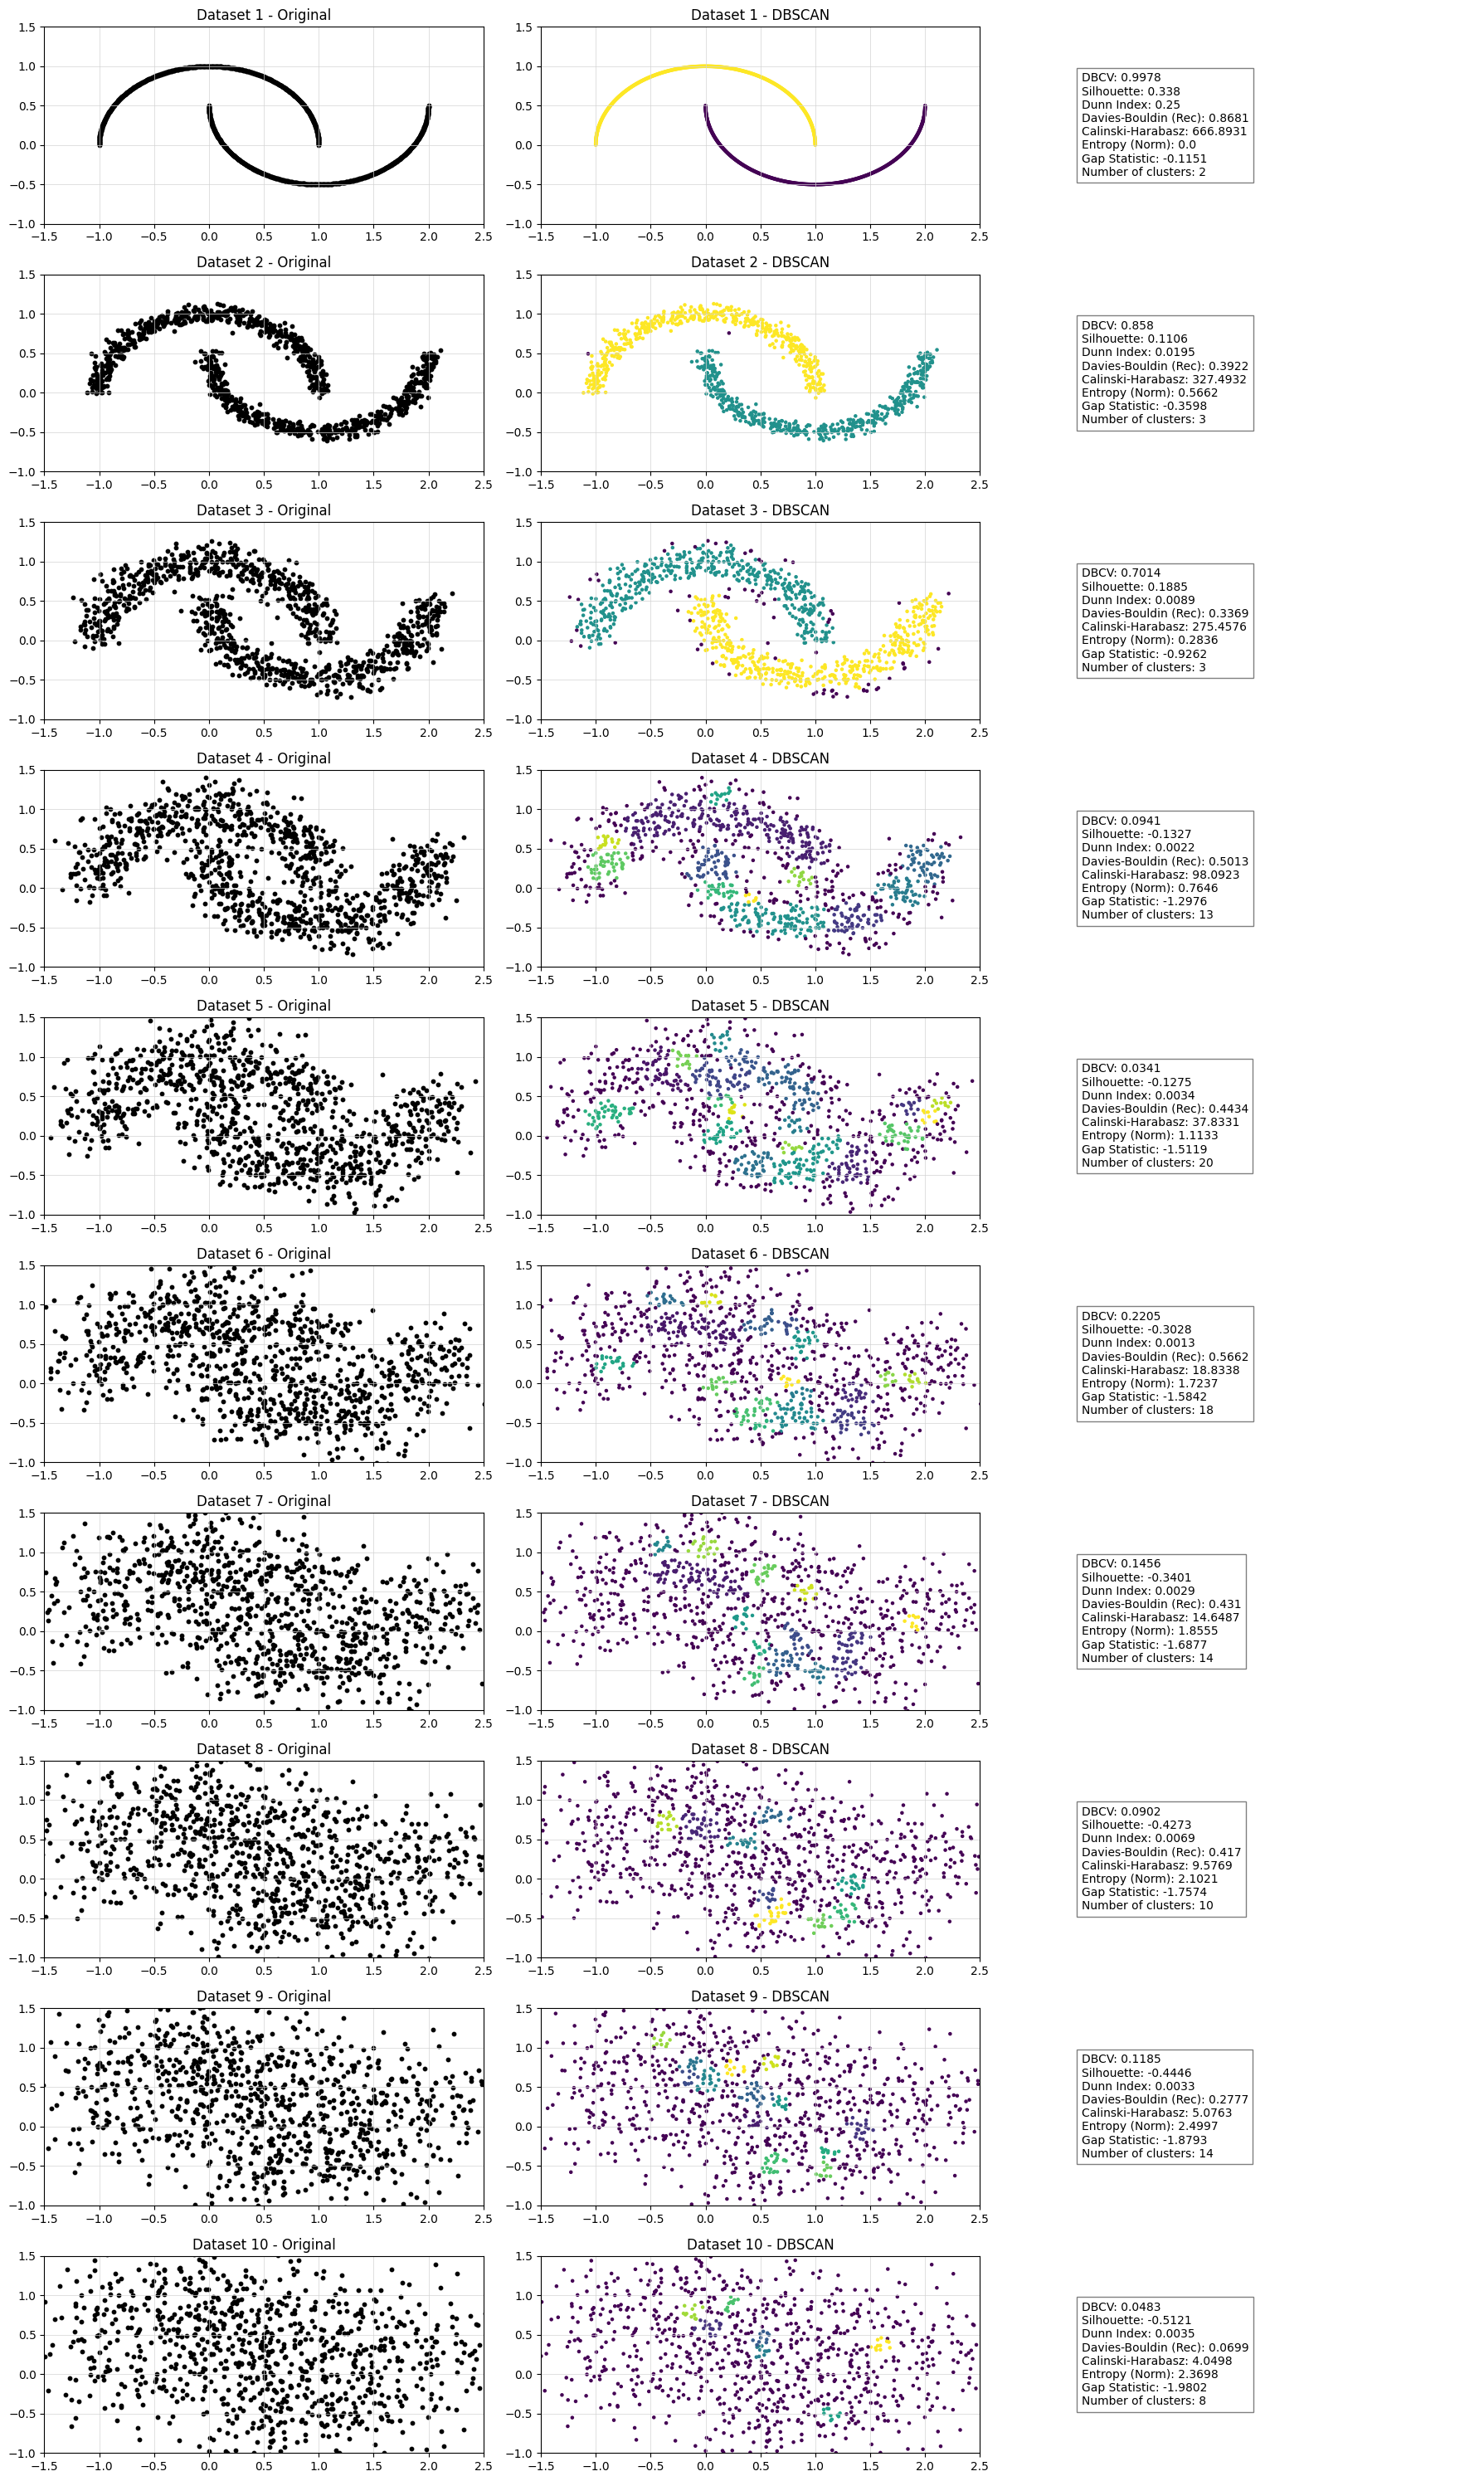

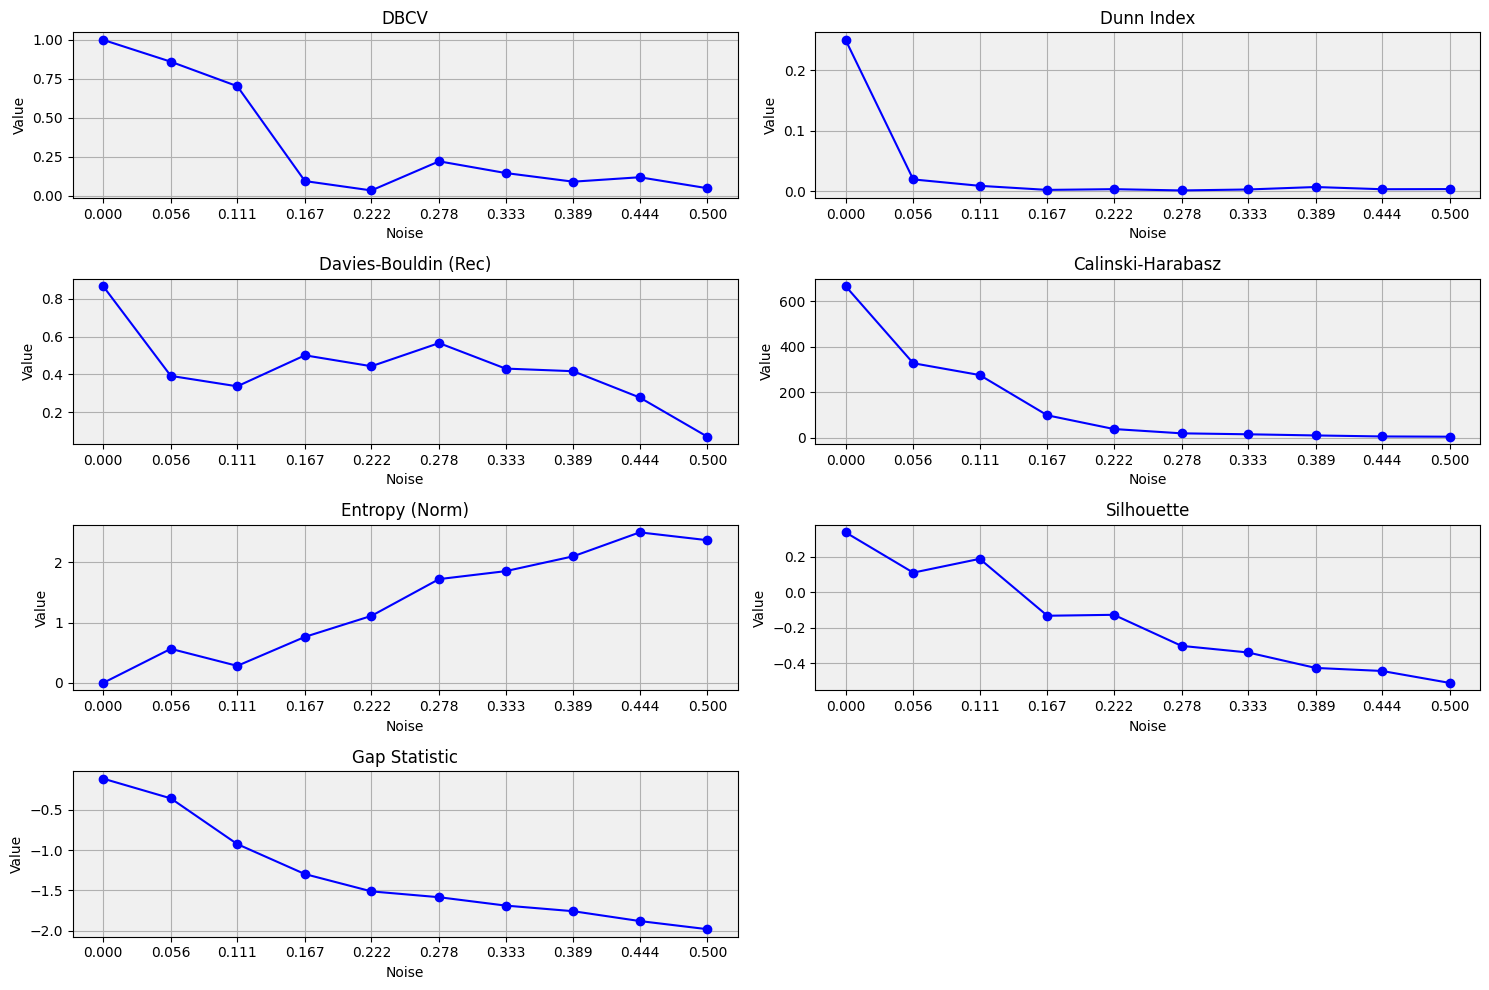

In [ ]:
datasets = generate_moon_datasets(30)
dbcv_total, dunn_total,davies_total, calinski_total,entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering(datasets)
noise = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]

    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()

**Circle**

Eseguito su 1000 campioni con normal dbcv. Questo perchè fastdbcv da errori di duplicati in fase di calcolo.
CI vuole circa mezz'ora.

Se diminuimo il numero di campioni a 300 il tempo diminuisce notevolmente a 2 minuti.

con 1000 camponi min_samples = 20
con 300 campioni min_samples = 6

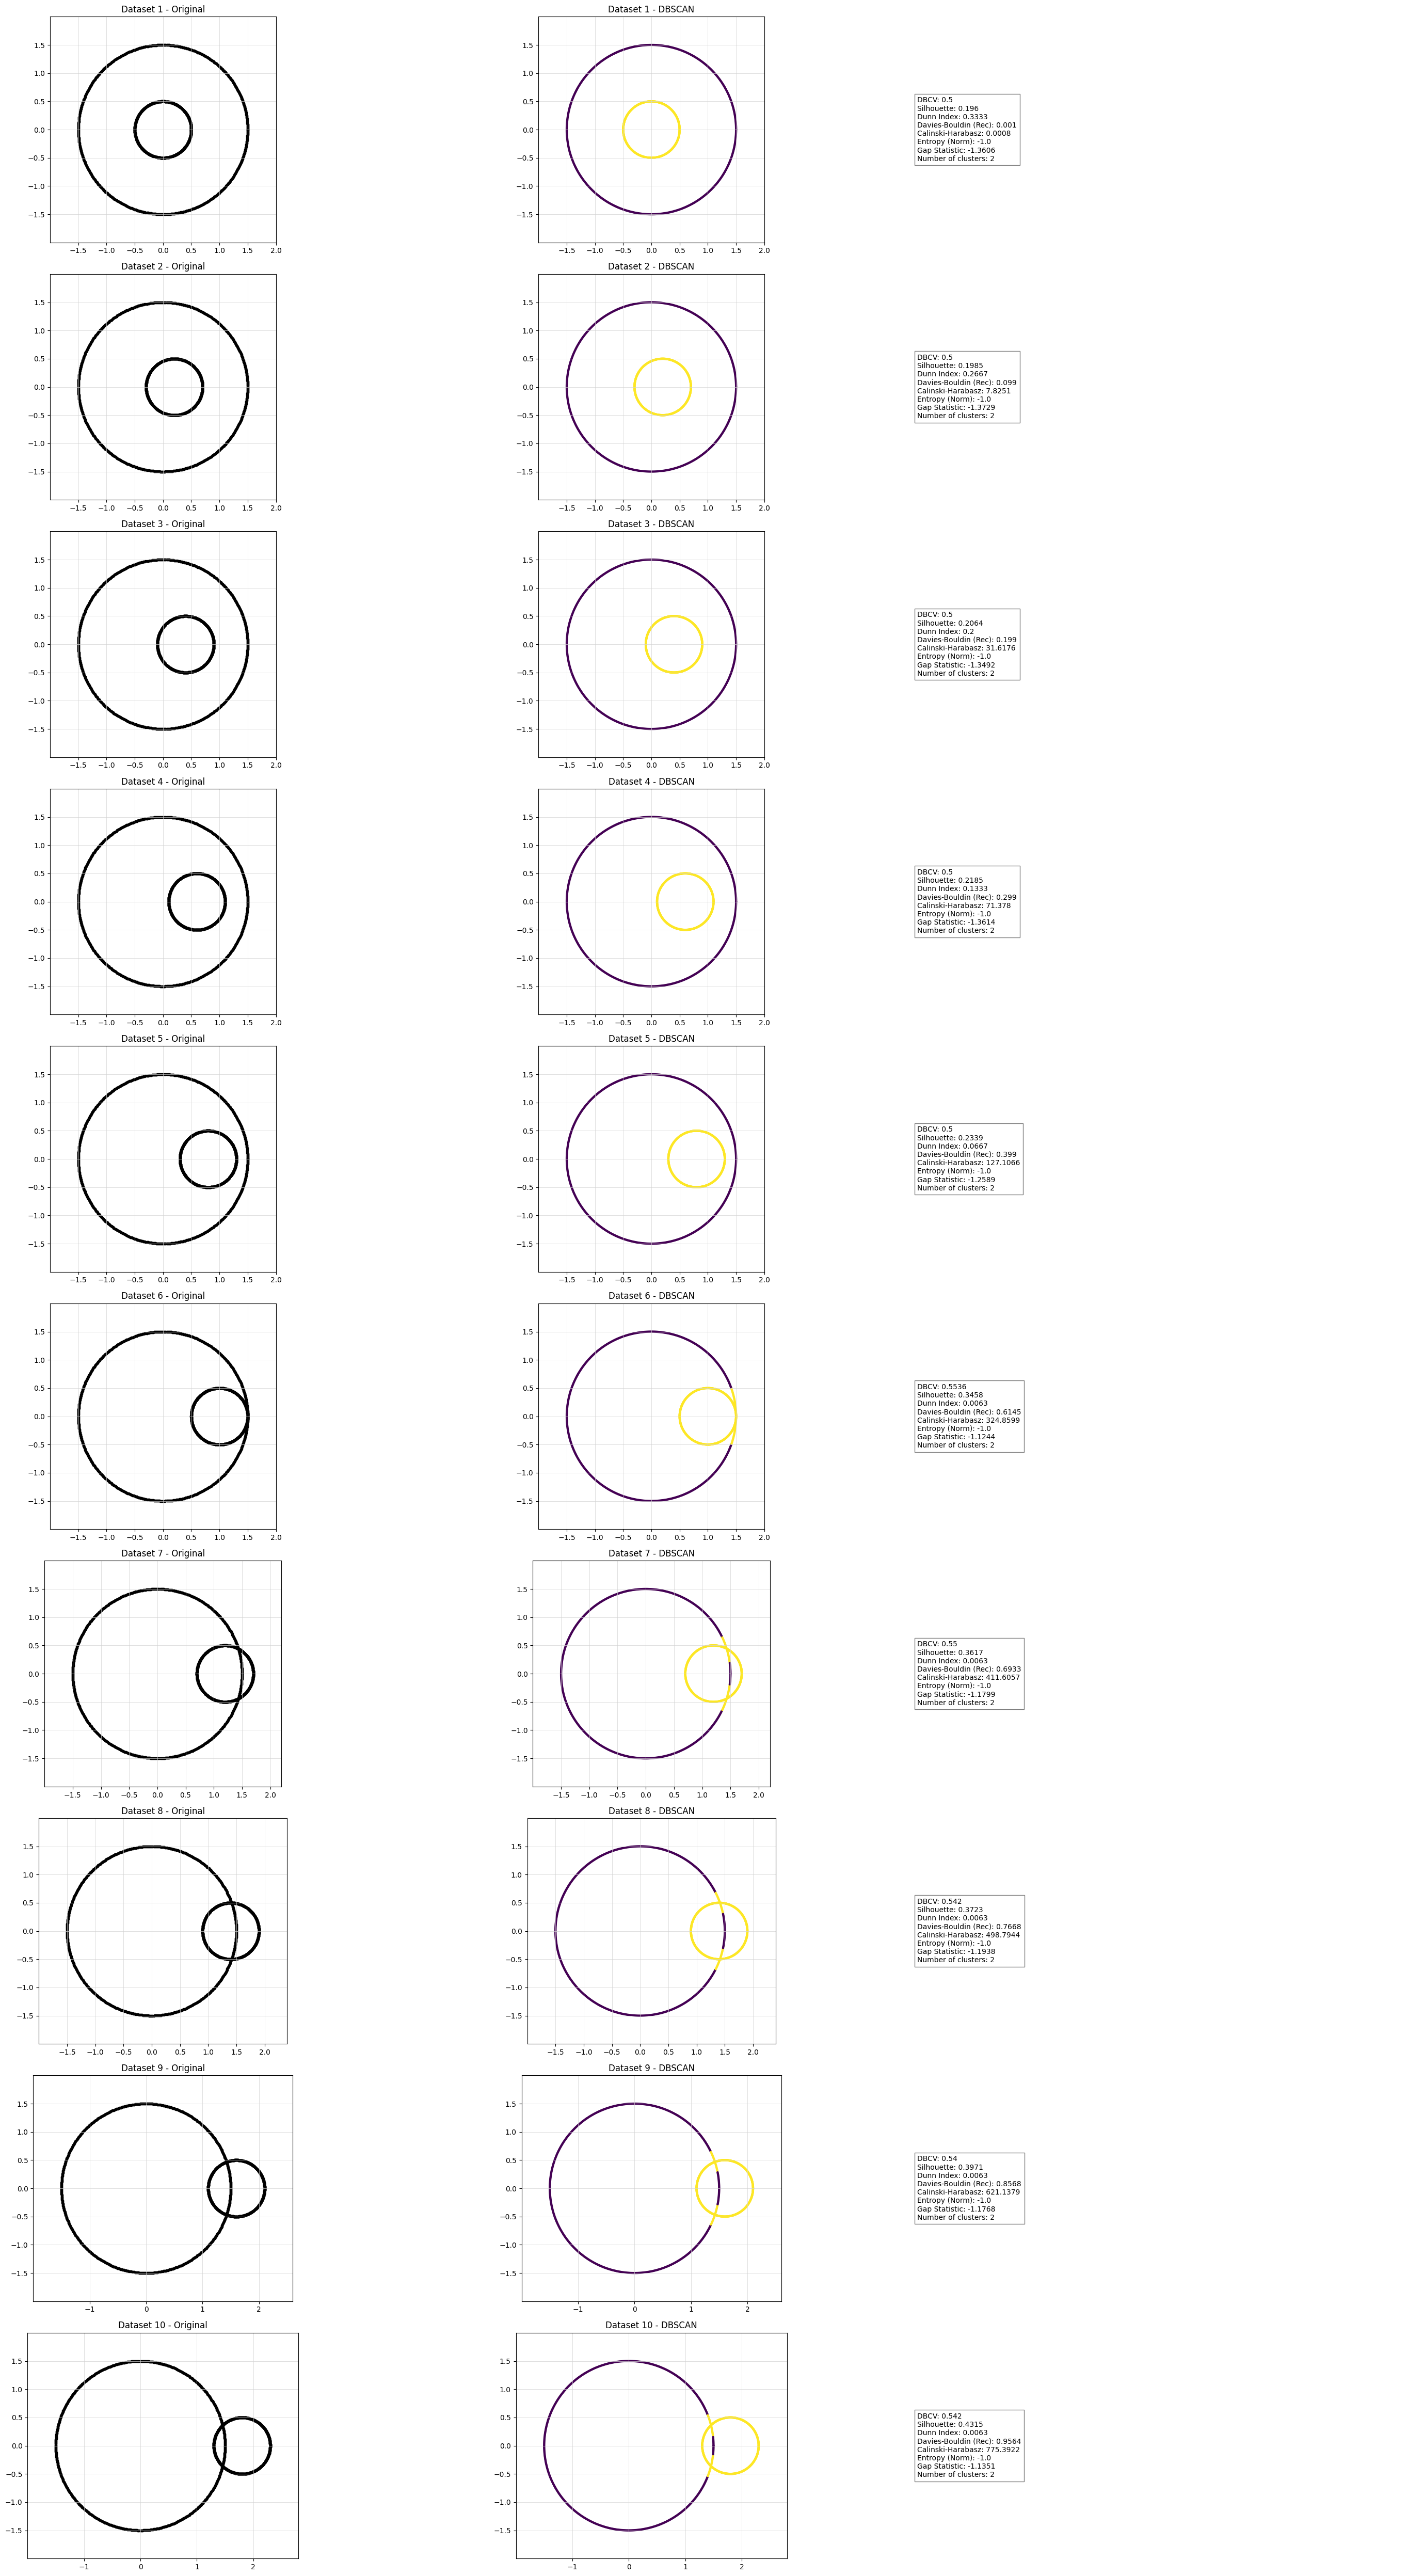

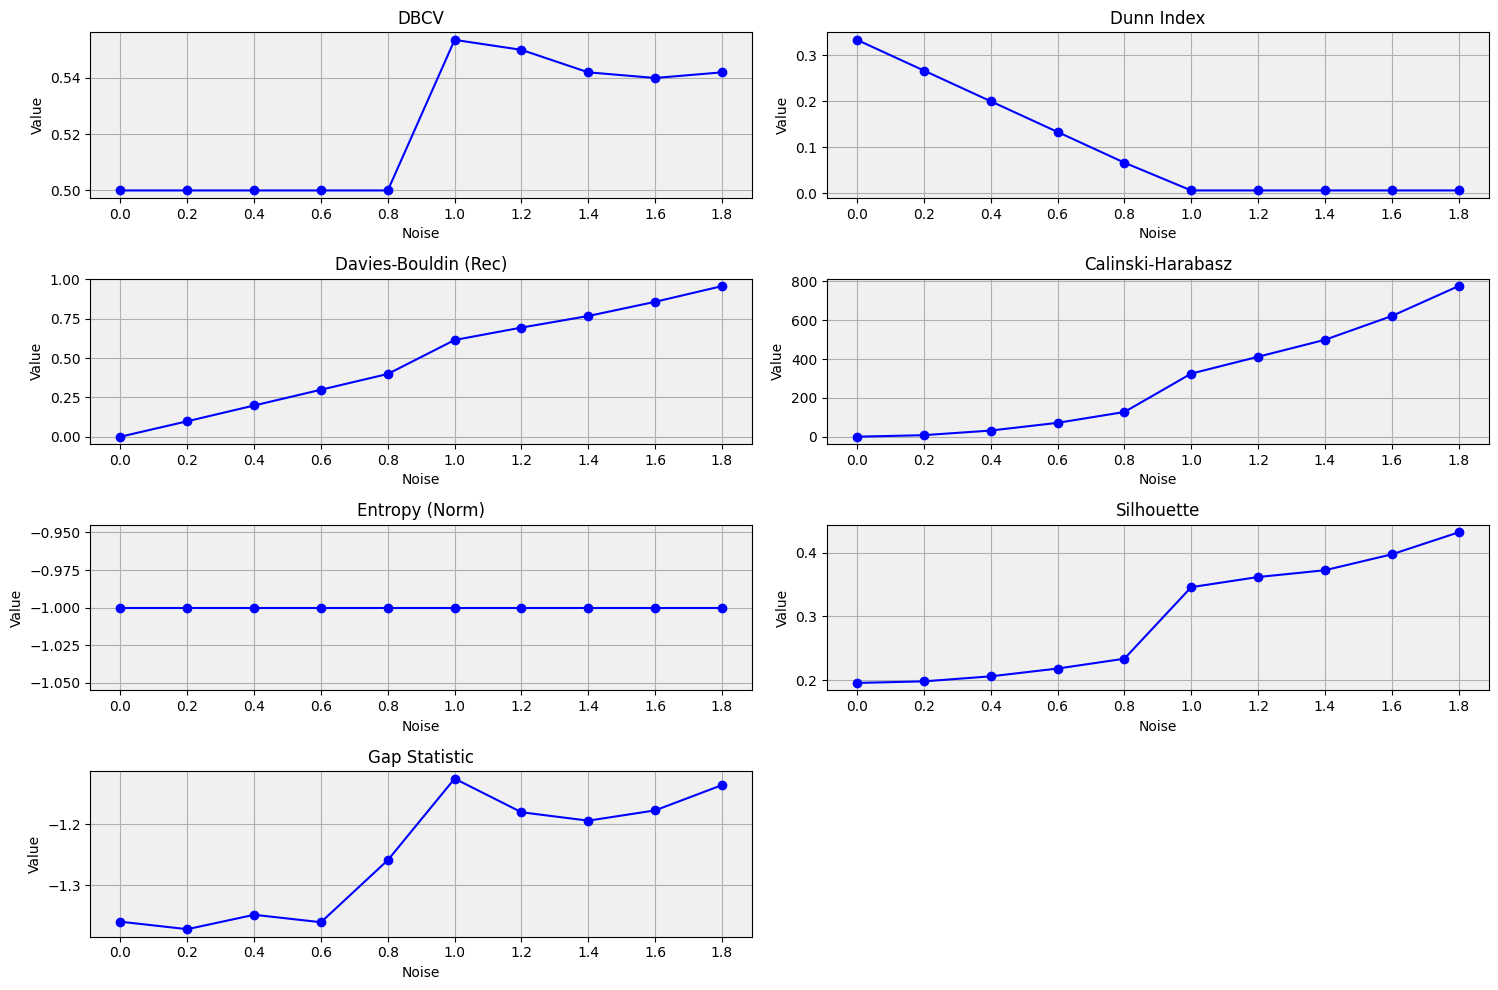

In [ ]:
n_datasets = 10
n_points_per_circle = 500
n_points_per_circle_inner = 500
inner_radius = 0.5
outer_radius = 1.5
initial_shift = (0, 0)
shift_increment = (0.2, 0)
datasets = generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment)

dbcv_total, dunn_total,davies_total, calinski_total,entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_circle(datasets)

noise = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


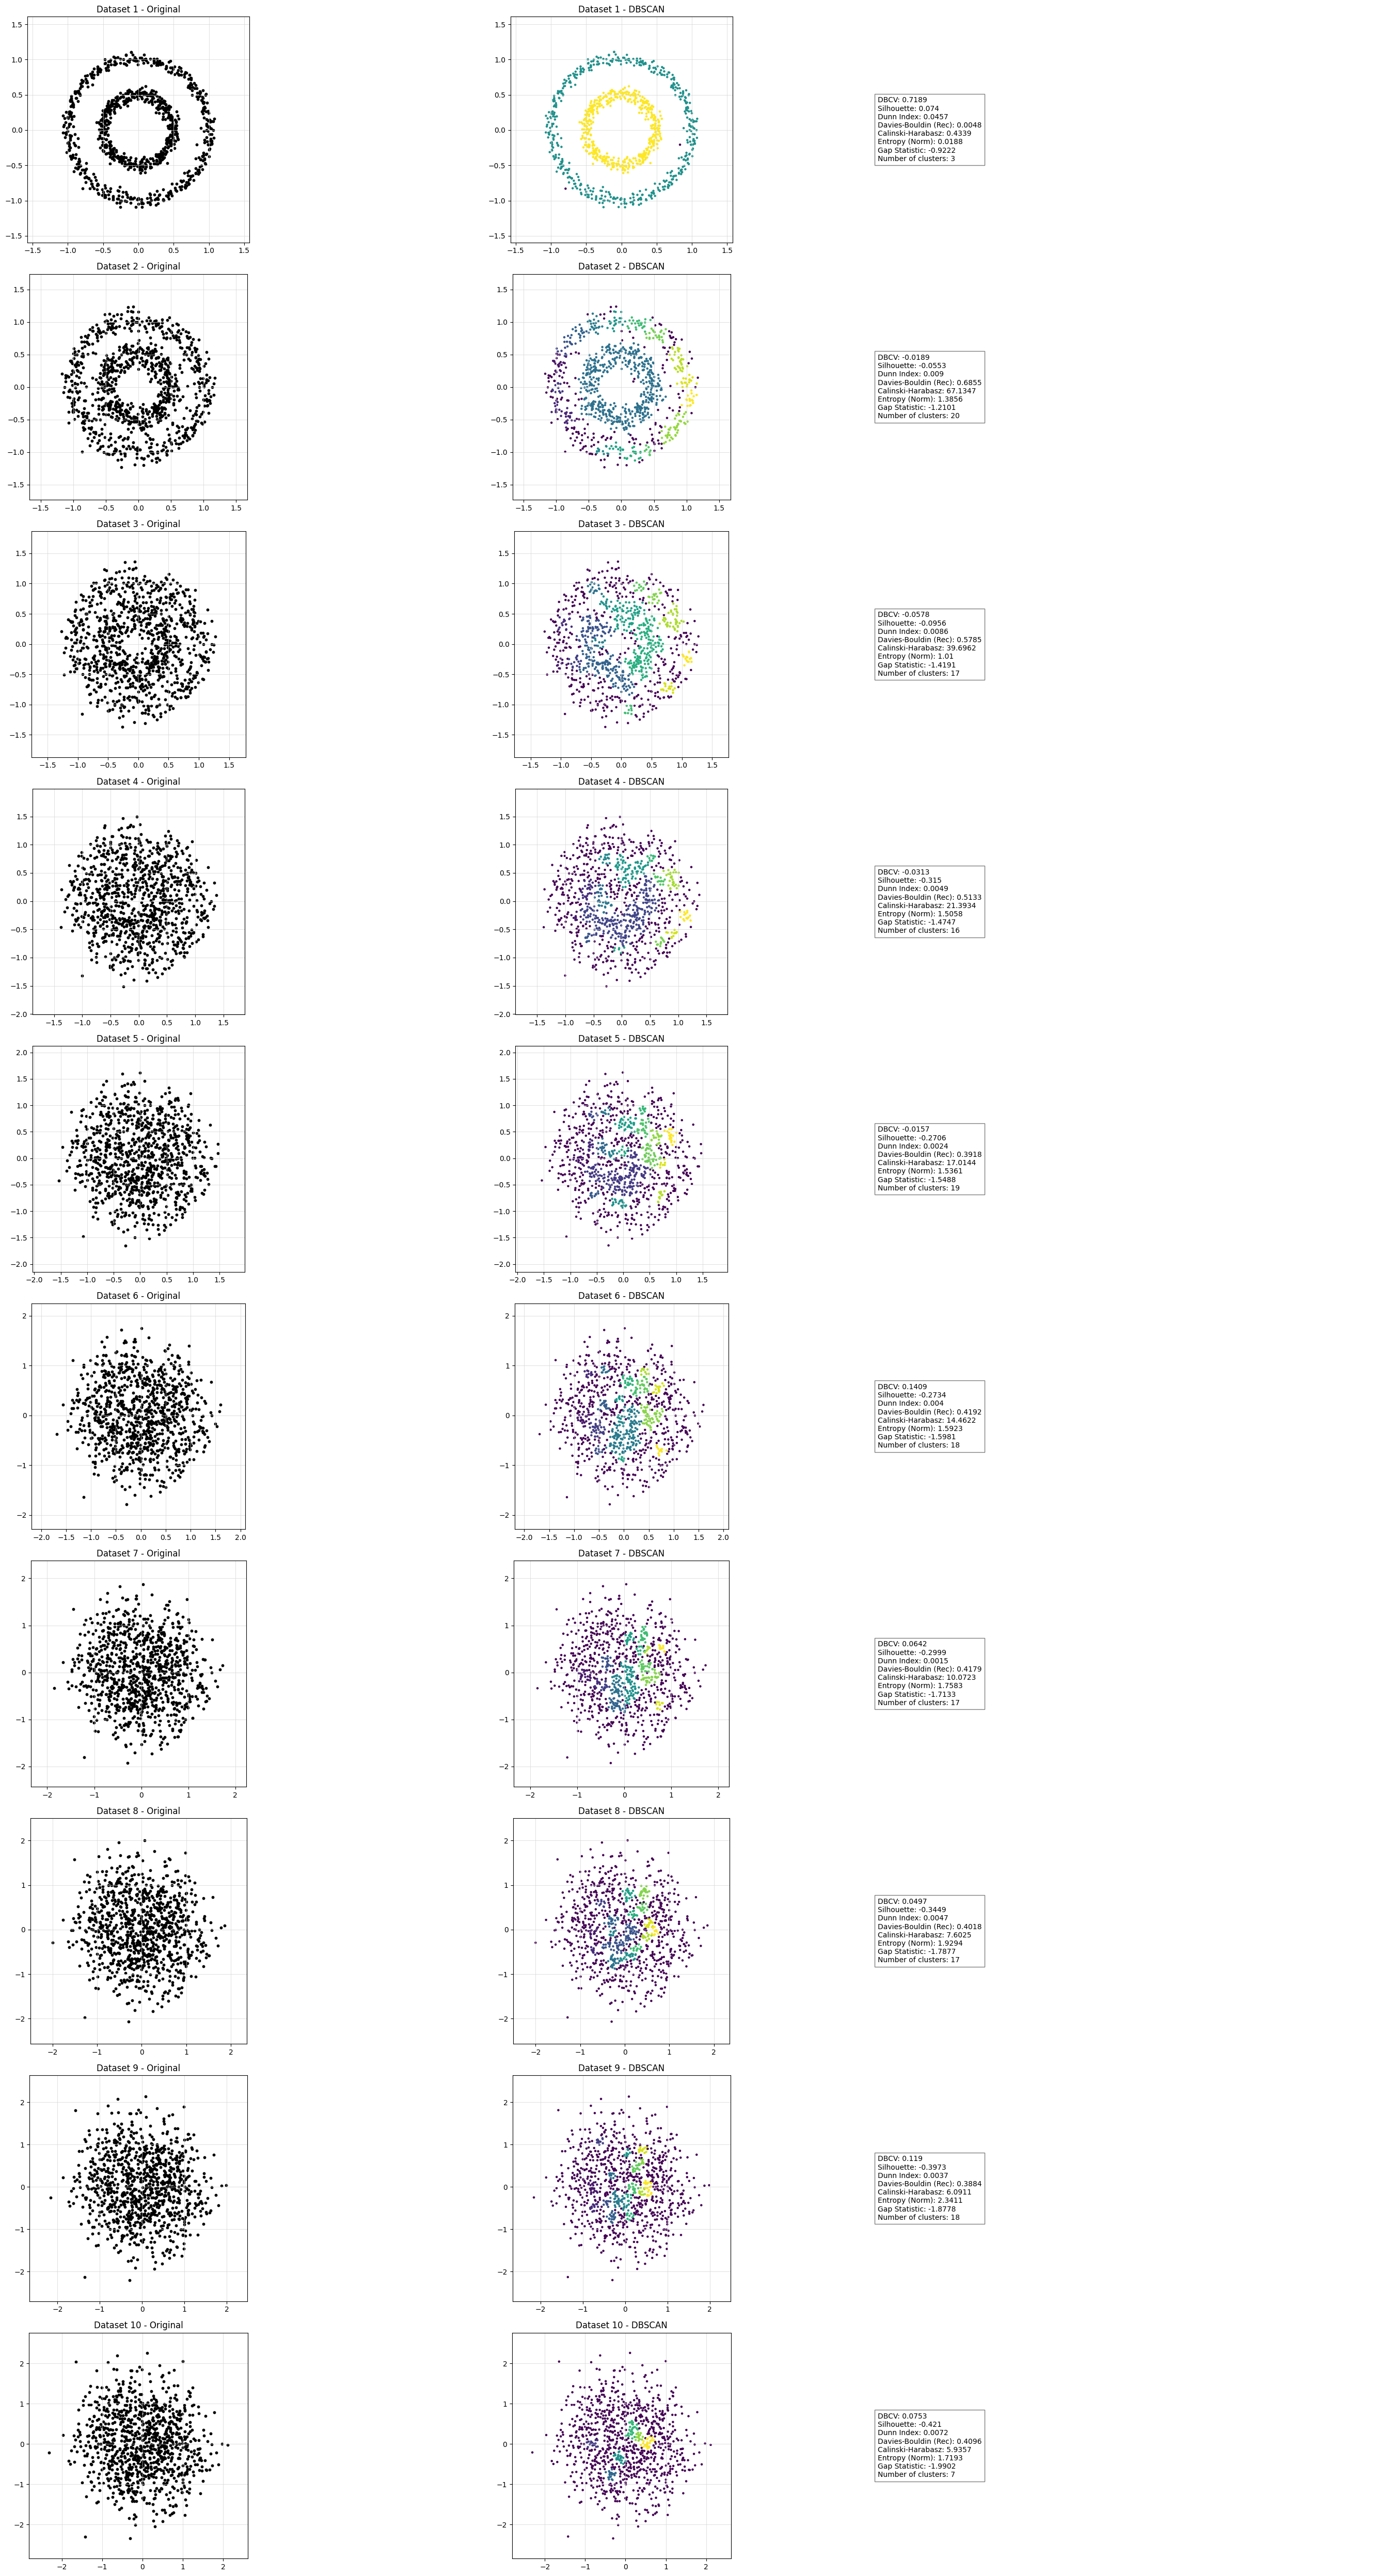

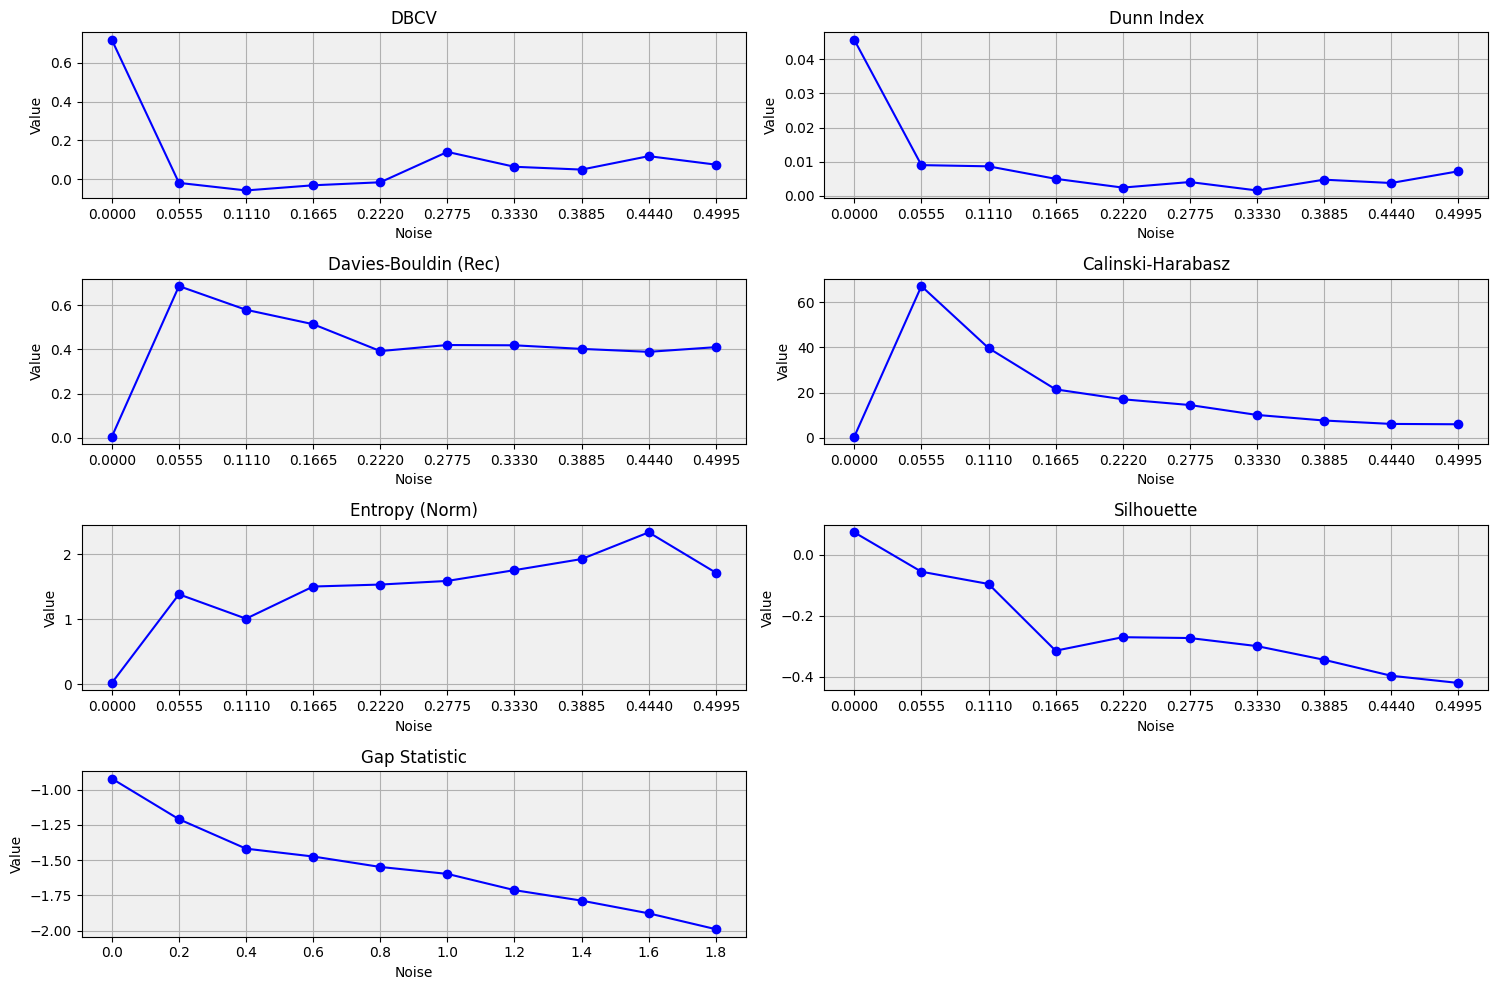

In [ ]:
n_datasets = 10
n_samples = 1000
noise_increment = 0.0555
seed = 4

#noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]


datasets = generate_noisy_circles(n_datasets, n_samples, noise_increment, seed)


dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_noisy_circles(datasets)
noise_levels = [i * noise_increment for i in range(n_datasets)]

dbcv_total = list(zip(dbcv_total, noise_levels))
dunn_total = list(zip(dunn_total, noise_levels))
davies_total = list(zip(davies_total, noise_levels))
calinski_total = list(zip(calinski_total, noise_levels))
entropy_total = list(zip(entropy_total, noise_levels))
silhouette_total = list(zip(silhouette_total, noise_levels))
gap_total = list(zip(gap_total, noise))
data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)

]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


**Tulipan**

Inserire dataset con punti più raggruppati

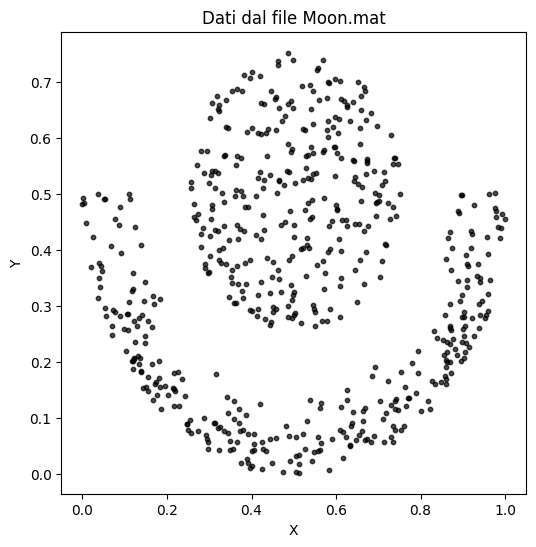

In [ ]:
# preso da https://github.com/adanjoga/cvik-toolbox/tree/master/datasets
#paper A survey of cluster validity indices for automatic data clustering using differential evolution

data = scipy.io.loadmat('/content/Moon.mat')

X = data['data'][:, 0]
Y = data['data'][:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(X, Y, color='black', alpha=0.7, s=10)
plt.title("Dati dal file Moon.mat")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


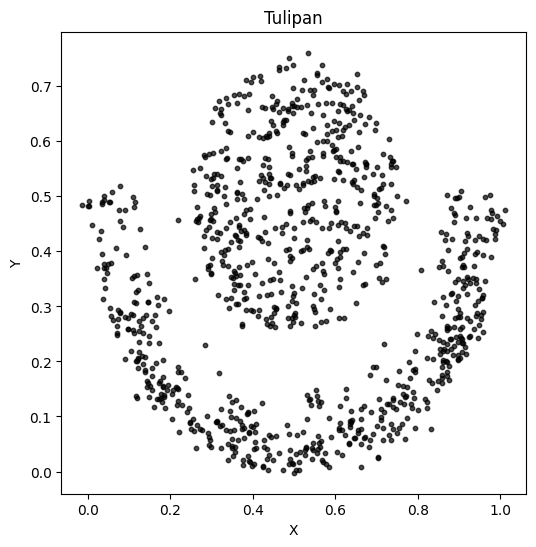

In [ ]:
data = scipy.io.loadmat('/content/Moon.mat')
X = data['data'][:, 0]
Y = data['data'][:, 1]


original_points = np.column_stack((X, Y))

# Generate 400 new points by sampling around the existing data
# Adding some random noise to keep them close to the existing distribution
num_new_points = 400
new_points = original_points[np.random.choice(original_points.shape[0], num_new_points)] + np.random.normal(0, 0.02, (num_new_points, 2))
augmented_data = np.vstack((original_points, new_points))
X_augmented = augmented_data[:, 0]
Y_augmented = augmented_data[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(X_augmented, Y_augmented, color='black', alpha=0.7, s=10)
plt.title("Tulipan")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

AL dataset originale sono dati aggiutni 400 punti (essendo 600 quelli attuali). I 600 attualirimangono fissi, viene aggiunto del rumore ai 400 inseriti , normalizzando il loro valore tra 0 e 1 in modo da essere inseritiall'interno del tulipano e non all'esterno

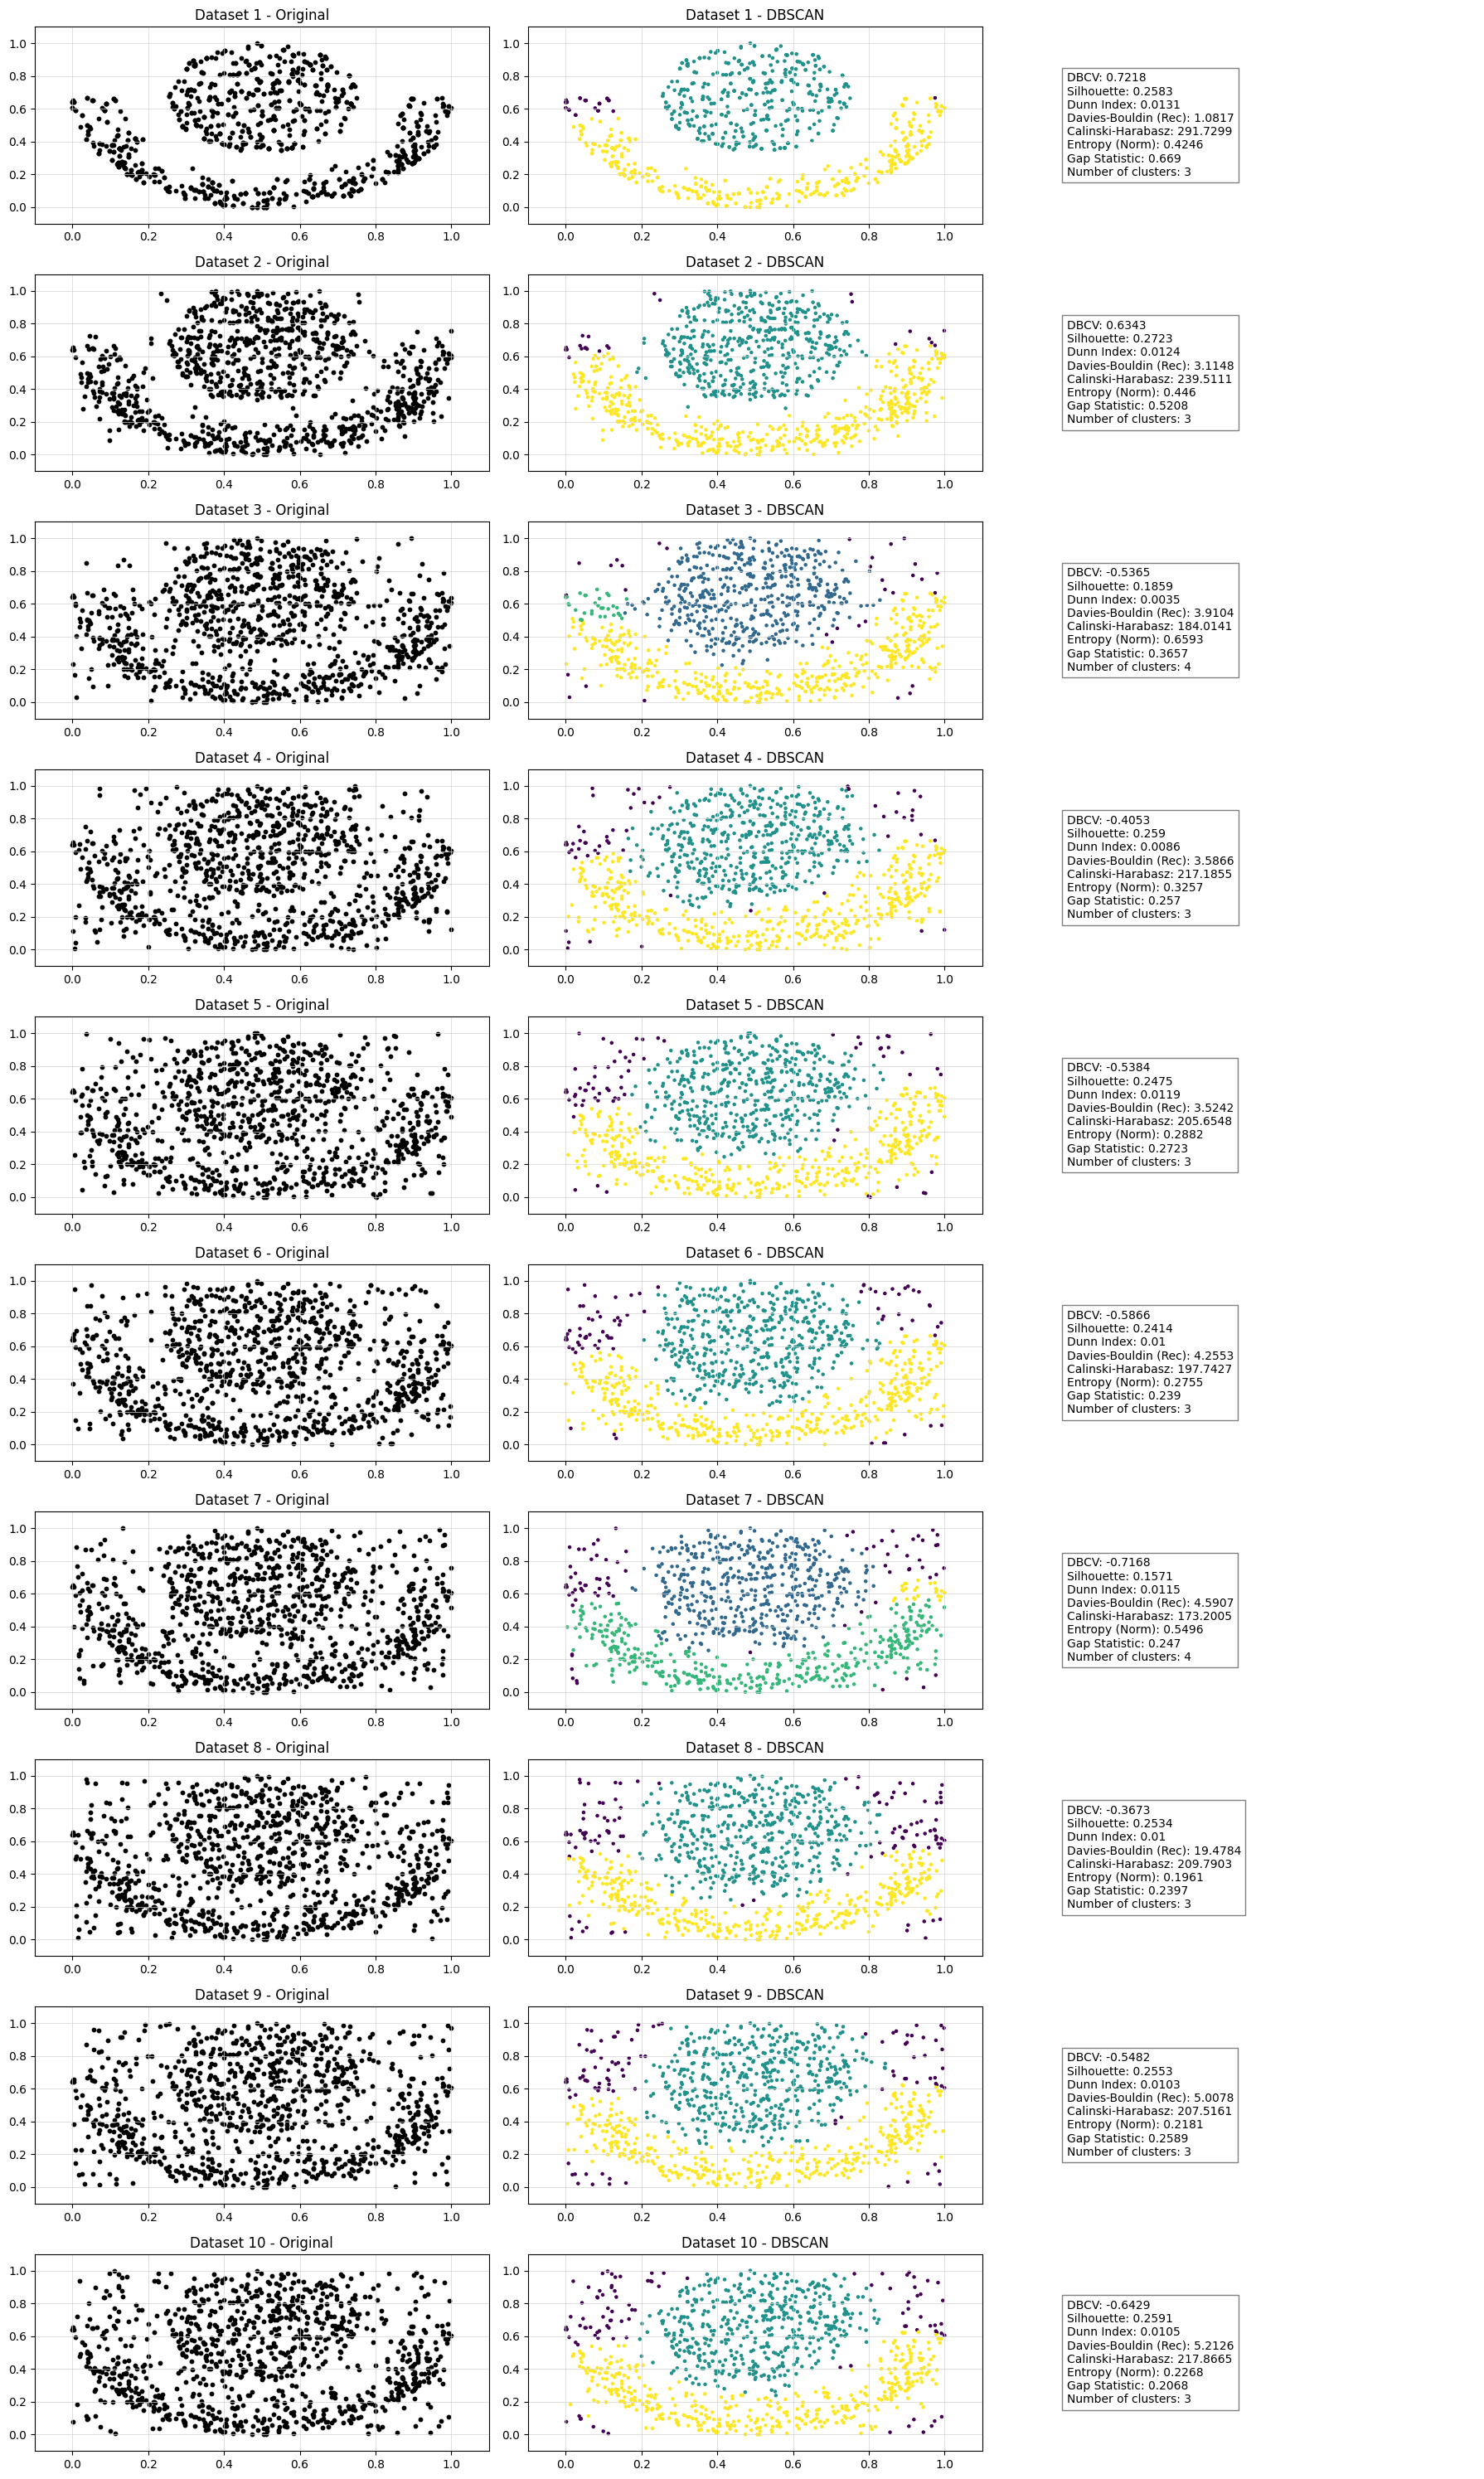

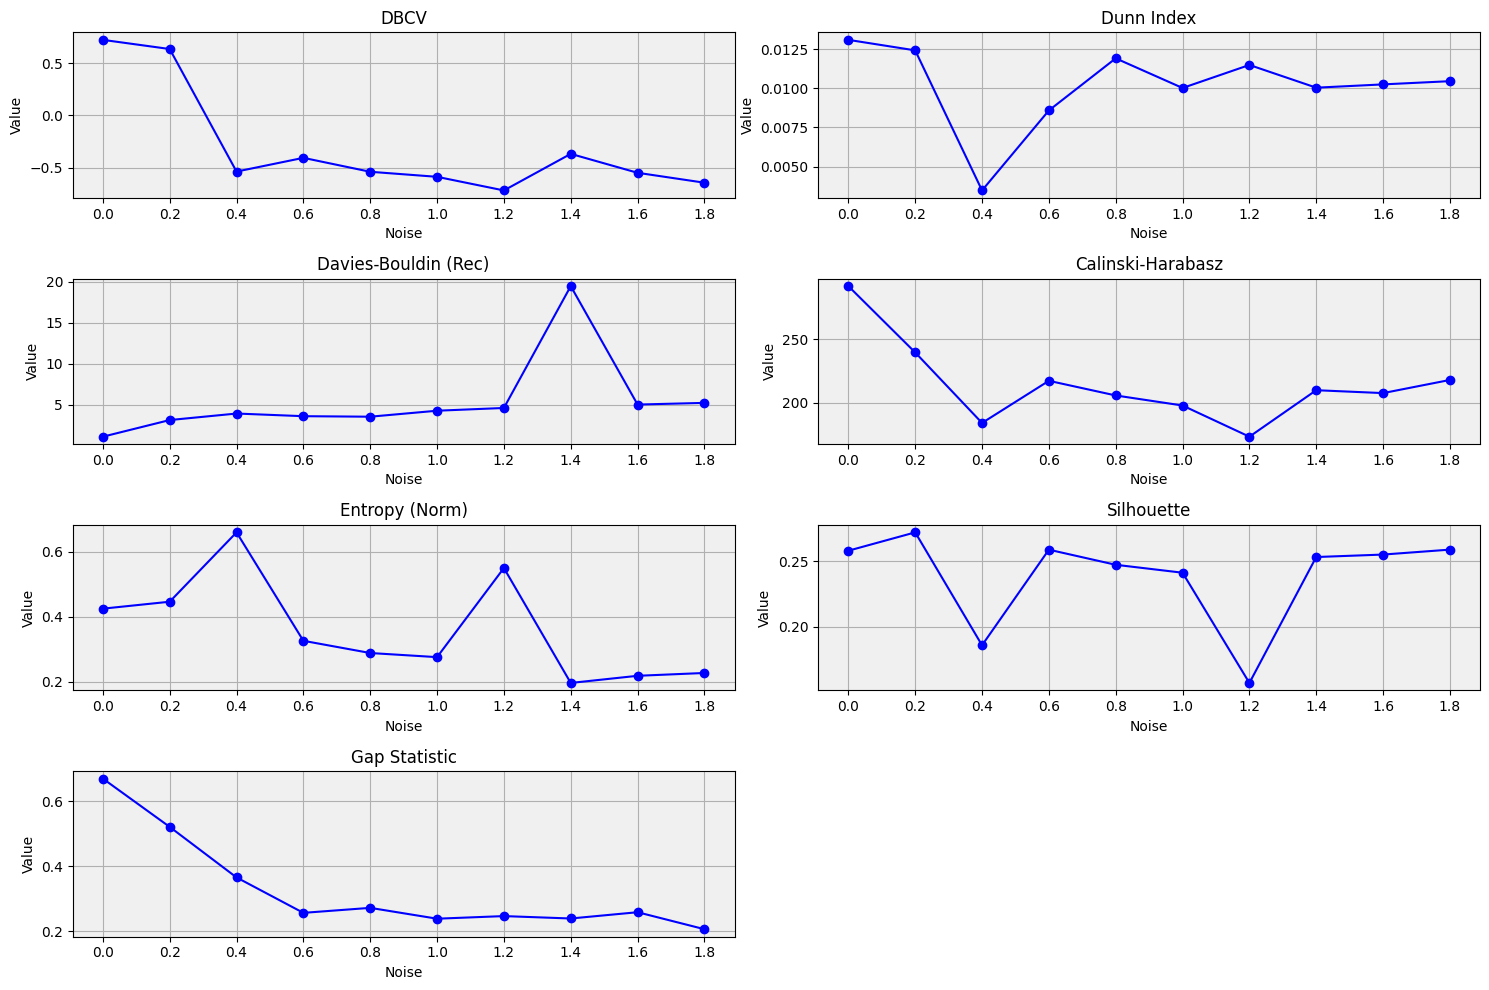

In [ ]:
data = scipy.io.loadmat('/content/Moon.mat')
X = data['data'][:, 0]
Y = data['data'][:, 1]
original_points = np.column_stack((X, Y))

min_vals = original_points.min(axis=0)
max_vals = original_points.max(axis=0)
normalized_points = (original_points - min_vals) / (max_vals - min_vals)

datasets = generate_augmented_datasets(30)
results = analyze_datasets_tulipan(datasets)
dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_tulipan(datasets, results)

noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))
for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)
    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)
    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


#**EHRs**

In [29]:
neuroblastoma=pd.read_csv("/content/10_7717_peerj_5665_dataYM2018_neuroblastoma.csv")
diabetes=pd.read_csv("/content/journal.pone.0216416_Takashi2019_diabetes_type1_dataset_preprocessed.csv")
sepsis=pd.read_csv("/content/journal.pone.0148699_S1_Text_Sepsis_SIRS_EDITED.csv")
heart_failure=pd.read_csv("/content/journal.pone.0158570_S2File_depression_heart_failure_v2.csv")
cardiac_arrest=pd.read_csv("/content/journal.pone.0175818_S1Dataset_Spain_cardiac_arrest_EDITED..csv")
df_metrics=pd.DataFrame()

metric_colors = {
    "DBCV Score": '#1f77b4',
    "Silhouette": '#ff7f0e',
    "Dunn Index": '#2ca02c',
    "Davies-Bouldin Norm": '#d62728',
    "Calinski-Harabasz": '#9467bd',
    "Shannon Entropy Norm": '#8c564b',
    "Optimal Gap Statistic": '#e377c2',
    "Clustering Truth": '#7f7f7f',
    "ARI": '#bcbd22'
}

metrics = [
    "DBCV Score", "Silhouette", "Dunn Index", "Davies-Bouldin Norm",
    "Calinski-Harabasz", "Entropy Norm", "Gap Statistic"
]

#**Neuroblastoma**

In [ ]:
neuroblastoma = neuroblastoma.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = neuroblastoma.columns
scaler_minmax = MinMaxScaler()
neuroblastoma_scaled = neuroblastoma.copy()
neuroblastoma_scaled[numerical_features] = scaler_minmax.fit_transform(neuroblastoma[numerical_features])
neuroblastoma_scaled.reset_index(drop=True, inplace=True)
neuroblastoma_scaled.drop_duplicates(inplace=True)
df_metrics_neuroblastoma = pd.DataFrame()
neuroblastoma_scaled

age  sex  site  stage  risk  time_months  \
0    1.0  0.0   0.0    1.0   1.0     0.060606   
1    1.0  0.0   0.0    1.0   1.0     0.181818   
2    0.5  0.0   0.0    1.0   1.0     0.242424   
3    0.5  0.0   0.0    1.0   1.0     0.070707   
4    0.5  0.0   0.0    1.0   1.0     0.464646   
..   ...  ...   ...    ...   ...          ...   
164  0.0  0.0   0.0    0.0   0.0     0.353535   
165  0.5  0.0   0.0    0.0   0.0     0.171717   
166  0.5  1.0   0.5    0.0   0.0     0.373737   
167  0.5  1.0   0.5    0.0   0.0     0.363636   
168  0.0  0.0   0.0    0.0   0.0     0.313131   

     autologous_stem_cell_transplantation  radiation  \
0                                     0.0        0.0   
1                                     0.0        1.0   
2                                     0.0        1.0   
3                                     0.0        0.0   
4                                     1.0        1.0   
..                                    ...        ...   
164                                   0.0        0.0   
165                                   0.0        0.0   
166                                   0.0        0.0   
167                                   0.0        0.0   
168                                   0.0        0.0   

     degree_of_differentiation  UH_or_FH  MYCN_status   surgical_methods  \
0                          0.0       0.0           1.0               1.0   
1                          0.0       0.0           1.0               1.0   
2                          0.5       0.0           1.0               0.0   
3                          0.5       0.0           1.0               1.0   
4                          0.5       0.0           1.0               0.0   
..                         ...       ...           ...               ...   
164                        0.0       0.0           1.0               0.0   
165                        0.5       1.0           1.0               1.0   
166                        1.0       1.0           1.0               0.0   
167                        0.5       1.0           1.0               0.0   
168                        0.0       0.0           1.0               0.0   

     outcome  
0        0.0  
1        1.0  
2        1.0  
3        0.0  
4        1.0  
..       ...  
164      0.0  
165      1.0  
166      0.0  
167      0.0  
168      0.0  

[168 rows x 13 columns]

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(neuroblastoma_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default = hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(neuroblastoma_scaled)
labels_default = hdbscan_cluster_default.fit_predict(neuroblastoma_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['HDBSCAN_pred'] = labels
methods = 'HDBSCAN'
methods_default = 'HDBSCAN DEFAULT'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels_default)
neuroblastoma_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)


min_cluster_size: 15, cluster_selection_epsilon: 0.05


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(neuroblastoma_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(neuroblastoma_scaled)
labels_default = dbscan_default.fit_predict(neuroblastoma_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN DEFAULT'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels_default)
neuroblastoma_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [ ]:
band = best_params_mean_shift(neuroblastoma_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(neuroblastoma_scaled)
labels_default = mean_shift_default.fit_predict(neuroblastoma_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['Mean_shift_pred'] = labels

methods = 'MEAN_SHIFT'
methods_default = 'MEAN_SHIFT_DEFAULT'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels_default)
neuroblastoma_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)
df_metrics_neuroblastoma

Best bandwidth: 1.516


Method  DBCV Score  Silhouette  Dunn Index  \
0             HDBSCAN        0.50        0.18    0.068486   
1     HDBSCAN DEFAULT       -0.03        0.24    0.146895   
2              DBSCAN        0.20       -0.06    0.122856   
3      DBSCAN DEFAULT        0.07        0.06    0.111232   
4          MEAN_SHIFT        0.50        0.33    0.450765   
5  MEAN_SHIFT_DEFAULT       -0.96        0.24    0.042548   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  
0                 0.40              22.48          0.45          -0.00  
1                 0.48              27.61          0.50           0.04  
2                 0.74               3.09          1.85           0.01  
3                 0.94              25.24          1.17          -0.07  
4                 1.50             102.17          1.41          -0.05  
5                 0.74              34.23          0.50          -0.16

**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(neuroblastoma_scaled)
cluster_similarity

[ 0  5  7  3 19  9 13 16  4  6 15 25 17 10 12 11 22 18 26 21 14 20  8  2
  1 23 24]
[-1  0  1  2  3  6  4  5  7  8  9 10 12 11 13]
[ 0 -1  1]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
0              0      -1        0    42.261905
1082           1      -1        1     5.952381
1036           2      -1       -1     5.357143
102            7       3        0     3.571429
150            3       6        0     2.976190
...          ...     ...      ...          ...
410            6       0        1     0.000000
409            6       0       -1     0.000000
408            6       0        0     0.000000
407            6      -1        1     0.000000
1214          24      13        1     0.000000

[1215 rows x 4 columns]

In [ ]:
neuroblastoma_scaled["DBSCAN_pred"] = neuroblastoma_scaled["DBSCAN_pred"].astype(object)
neuroblastoma_scaled["HDBSCAN_pred"] = neuroblastoma_scaled["HDBSCAN_pred"].astype(object)
neuroblastoma_scaled["Mean_shift_pred"] = neuroblastoma_scaled["Mean_shift_pred"].astype(object)

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'


neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1})
    .astype(int)
)

same_value_count = (neuroblastoma_scaled["HDBSCAN_pred"] == neuroblastoma_scaled["DBSCAN_pred"]) & \
                   (neuroblastoma_scaled["DBSCAN_pred"] == neuroblastoma_scaled["Mean_shift_pred"])

total_same_value = same_value_count.sum()
total_rows = len(neuroblastoma_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(neuroblastoma_scaled)
df_metrics_neuroblastoma['Clustering Truth'] = percentage_same_value
df_metrics_neuroblastoma['ARI'] = ari
df_metrics_neuroblastoma = df_metrics_neuroblastoma.sort_values('DBCV Score', ascending=False)
df_metrics_neuroblastoma

Totale delle righe con lo stesso valore: 75
Percentuale rispetto al totale: 44.64 %


Method  DBCV Score  Silhouette  Dunn Index  \
0             HDBSCAN        0.50        0.18    0.068486   
4          MEAN_SHIFT        0.50        0.33    0.450765   
2              DBSCAN        0.20       -0.06    0.122856   
3      DBSCAN DEFAULT        0.07        0.06    0.111232   
1     HDBSCAN DEFAULT       -0.03        0.24    0.146895   
5  MEAN_SHIFT_DEFAULT       -0.96        0.24    0.042548   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
0                 0.40              22.48          0.45          -0.00   
4                 1.50             102.17          1.41          -0.05   
2                 0.74               3.09          1.85           0.01   
3                 0.94              25.24          1.17          -0.07   
1                 0.48              27.61          0.50           0.04   
5                 0.74              34.23          0.50          -0.16   

   Clustering Truth      ARI  
0             0.446  0.29584  
4             0.446  0.29584  
2             0.446  0.29584  
3             0.446  0.29584  
1             0.446  0.29584  
5             0.446  0.29584

In [ ]:
df_metrics_neuroblastoma["Silhouette"] = (df_metrics_neuroblastoma["Silhouette"] + 1) / 2
df_metrics_neuroblastoma["DBCV Score"] = (df_metrics_neuroblastoma["DBCV Score"] + 1) / 2
df_metrics_neuroblastoma["Dunn Index"] = (erf(df_metrics_neuroblastoma["Dunn Index"]) + 1) / 2
df_metrics_neuroblastoma["Davies-Bouldin Norm"] = (erf(df_metrics_neuroblastoma["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_neuroblastoma["Calinski-Harabasz"] = 1 - (1 / df_metrics_neuroblastoma["Calinski-Harabasz"])
df_metrics_neuroblastoma["Entropy Norm"] = (erf(df_metrics_neuroblastoma["Entropy Norm"]) + 1) / 2
df_metrics_neuroblastoma["Gap Statistic"] = (erf(df_metrics_neuroblastoma["Gap Statistic"]) + 1) / 2

df_metrics_neuroblastoma

Method  DBCV Score  Silhouette  Dunn Index  \
0             HDBSCAN       0.750       0.590    0.538579   
4          MEAN_SHIFT       0.750       0.665    0.738093   
2              DBSCAN       0.600       0.470    0.568967   
3      DBSCAN DEFAULT       0.535       0.530    0.562498   
1     HDBSCAN DEFAULT       0.485       0.620    0.582284   
5  MEAN_SHIFT_DEFAULT       0.020       0.620    0.523991   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
0             0.714196           0.955516      0.737741       0.500000   
4             0.983053           0.990212      0.976926       0.471814   
2             0.852339           0.676375      0.995556       0.505642   
3             0.908136           0.960380      0.951000       0.460571   
1             0.751375           0.963781      0.760250       0.522556   
5             0.852339           0.970786      0.760250       0.410494   

   Clustering Truth      ARI  
0             0.446  0.29584  
4             0.446  0.29584  
2             0.446  0.29584  
3             0.446  0.29584  
1             0.446  0.29584  
5             0.446  0.29584

In [ ]:
distance_table_neuroblastoma = df_metrics_neuroblastoma.copy()

for metric in metrics:
    distance_table_neuroblastoma[metric] = np.sqrt((df_metrics_neuroblastoma[metric] - df_metrics_neuroblastoma["Clustering Truth"]) ** 2)

distance_table_neuroblastoma = distance_table_neuroblastoma.sort_values(by="DBCV Score", ascending=True)
distance_table_neuroblastoma.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_neuroblastoma.columns
]

distance_table_neuroblastoma

Method  DBCV Score Distance  Silhouette Distance  \
1     HDBSCAN DEFAULT                0.039                0.174   
3      DBSCAN DEFAULT                0.089                0.084   
2              DBSCAN                0.154                0.024   
0             HDBSCAN                0.304                0.144   
4          MEAN_SHIFT                0.304                0.219   
5  MEAN_SHIFT_DEFAULT                0.426                0.174   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
1             0.136284                      0.305375   
3             0.116498                      0.462136   
2             0.122967                      0.406339   
0             0.092579                      0.268196   
4             0.292093                      0.537053   
5             0.077991                      0.406339   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
1                    0.517781               0.314250                0.076556   
3                    0.514380               0.505000                0.014571   
2                    0.230375               0.549556                0.059642   
0                    0.509516               0.291741                0.054000   
4                    0.544212               0.530926                0.025814   
5                    0.524786               0.314250                0.035506   

   Clustering Truth      ARI  
1             0.446  0.29584  
3             0.446  0.29584  
2             0.446  0.29584  
0             0.446  0.29584  
4             0.446  0.29584  
5             0.446  0.29584

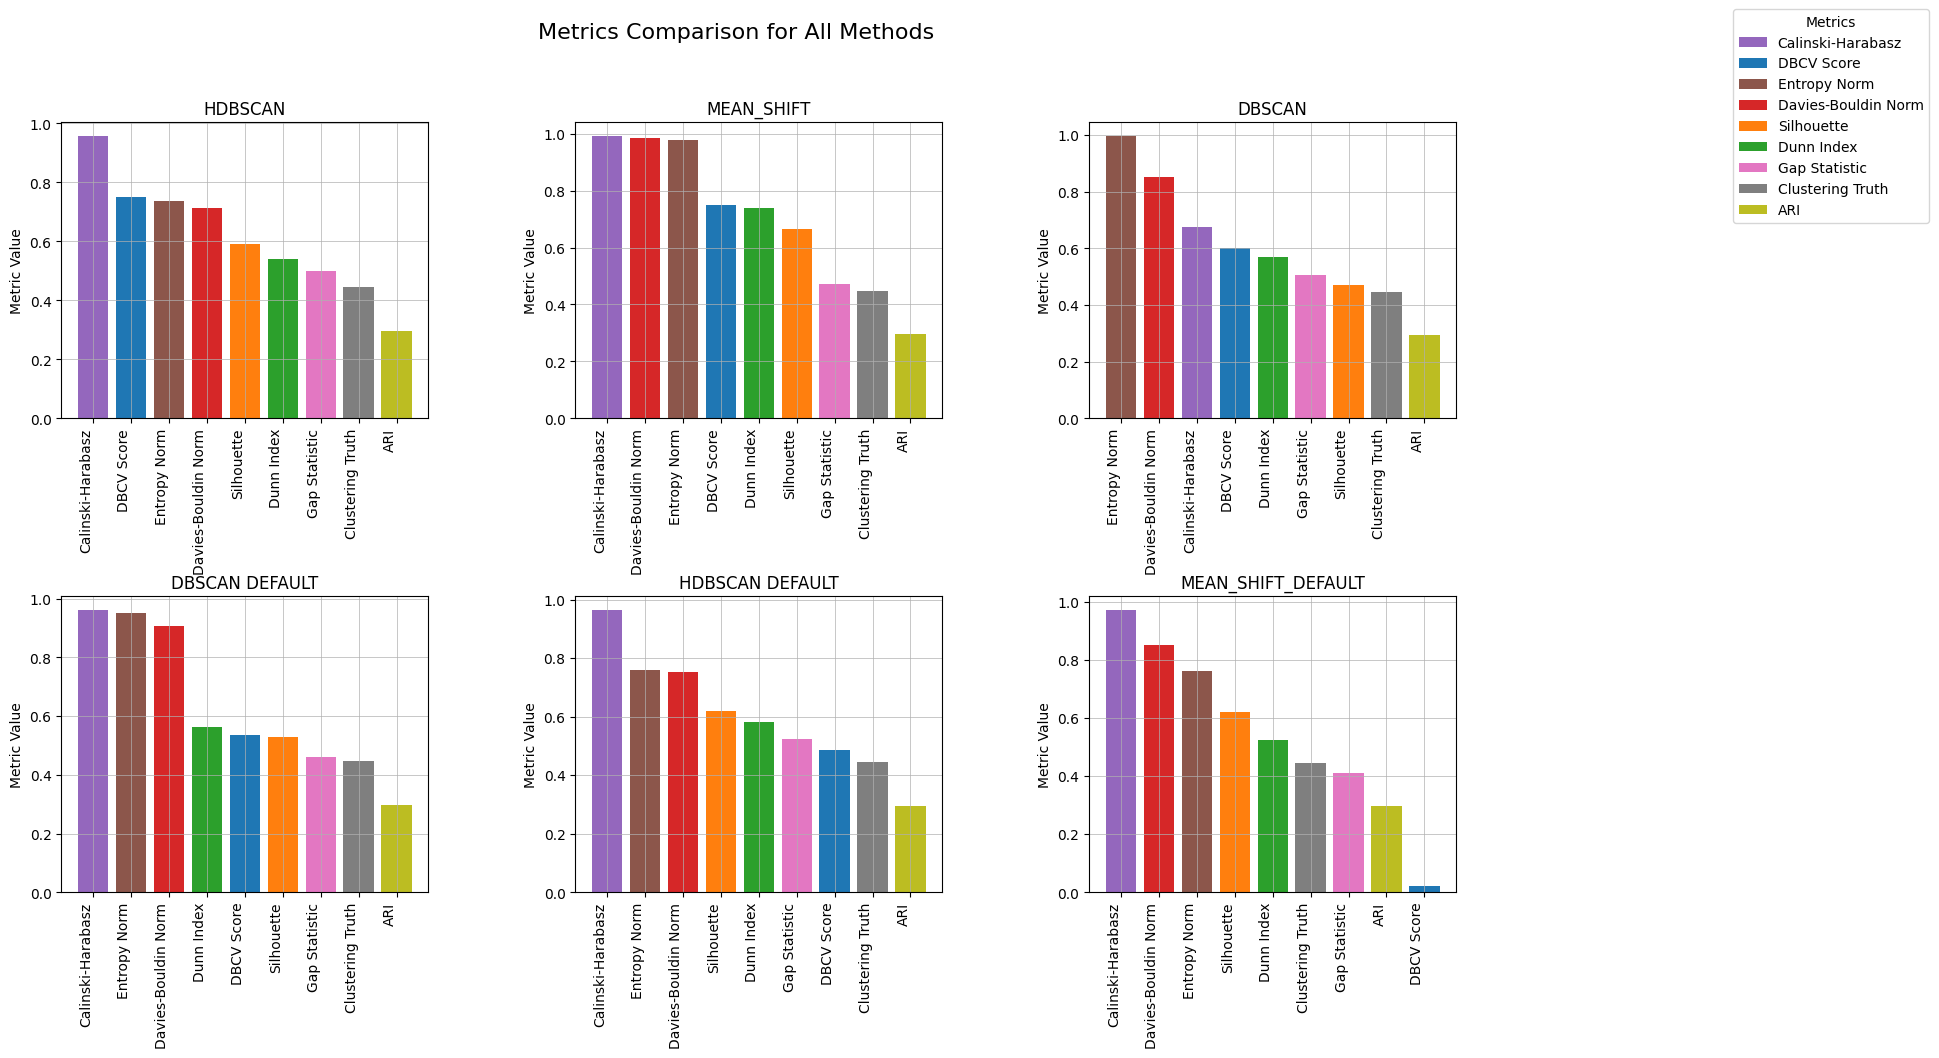

In [ ]:
df_metrics_neuroblastoma.set_index("Method", inplace=True)

methods = df_metrics_neuroblastoma.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_neuroblastoma.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, methods):
    sorted_metrics = df_metrics_neuroblastoma.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=90, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

plt.show()


#**Diabetes**

In [ ]:
diabetes = diabetes.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = diabetes.columns
scaler_minmax = MinMaxScaler()
diabetes_scaled = diabetes.copy()
diabetes_scaled[numerical_features] = scaler_minmax.fit_transform(diabetes[numerical_features])
diabetes_scaled.reset_index(drop=True, inplace=True)
diabetes_scaled.drop_duplicates(inplace=True)
df_metrics_diabetes = pd.DataFrame()
diabetes_scaled

age  duration.of.diabetes  body_mass_index       TDD     basal  \
0   0.370370              0.233333           0.1875  0.421053  0.209302   
1   0.370370              0.500000           0.4375  0.726316  0.531561   
2   0.407407              0.533333           0.1250  0.175940  0.348837   
3   0.148148              0.233333           0.1250  0.666165  0.468439   
4   0.666667              0.833333           0.8750  0.681203  0.707641   
..       ...                   ...              ...       ...       ...   
62  0.555556              0.600000           0.0000  0.470677  1.000000   
63  0.962963              0.800000           0.3750  0.184962  0.232558   
64  0.000000              0.166667           0.4375  0.846617  0.860465   
65  0.555556              0.633333           0.3125  0.275188  0.531561   
66  0.592593              0.533333           0.2500  0.293233  0.548173   

       bolus     HbA1c      eGFR  perc.body.fat  adiponectin  \
0   0.529101  0.214286  0.422018       0.971429     0.375000   
1   0.716049  0.482143  0.546527       0.980952     0.225694   
2   0.167549  0.125000  0.448231       0.971429     0.437500   
3   0.679012  0.375000  0.550459       0.971429     0.107639   
4   0.567901  0.446429  0.758847       0.990476     0.357639   
..       ...       ...       ...            ...          ...   
62  0.167549  0.732143  0.000000       0.971429     0.381944   
63  0.239859  0.321429  0.342071       0.980952     0.288194   
64  0.682540  0.500000  0.832241       0.971429     0.343750   
65  0.186949  0.303571  0.563565       0.971429     0.253472   
66  0.199295  0.089286  0.568807       0.971429     0.579861   

    free.testosterone       SMI  grip.strength  knee.extension.strength  \
0            0.022599  0.388889       0.358090                 0.312500   
1            0.531073  0.555556       0.607427                 0.542763   
2            0.039548  0.166667       0.042440                 0.312500   
3            0.050847  0.277778       0.381963                 0.299342   
4            0.542373  0.777778       0.671088                 0.500000   
..                ...       ...            ...                      ...   
62           0.016949  0.111111       0.209549                 0.542763   
63           0.276836  0.500000       0.233422                 0.154605   
64           0.954802  0.694444       0.612732                 0.572368   
65           0.429379  0.694444       1.000000                 0.674342   
66           0.220339  0.444444       0.026525                 0.161184   

    gait.speed      ucOC        OC  weight_kg  insulin_regimen_binary  \
0     0.000000  1.000000  1.000000   0.139482                     0.0   
1     0.583333  0.188172  0.254630   0.603659                     1.0   
2     0.333333  0.080645  0.101852   0.142683                     0.0   
3     0.500000  0.161290  0.187500   0.054878                     1.0   
4     0.416667  0.107527  0.134259   1.000000                     0.0   
..         ...       ...       ...        ...                     ...   
62    0.750000  0.838710  0.879630   0.000000                     1.0   
63    0.583333  0.086022  0.150463   0.164634                     1.0   
64    0.583333  0.424731  0.479167   0.457317                     1.0   
65    0.750000  0.231183  0.245370   0.384146                     1.0   
66    0.500000  0.000000  0.016204   0.213415                     0.0   

    sex_0man_1woman  
0               1.0  
1               0.0  
2               1.0  
3               1.0  
4               0.0  
..              ...  
62              1.0  
63              0.0  
64              0.0  
65              0.0  
66              1.0  

[67 rows x 20 columns]

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(diabetes_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(diabetes_scaled)
labels_default = hdbscan_cluster_default.fit_predict(diabetes_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels)
diabetes_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN DEFAULT'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels_default)
diabetes_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)


min_cluster_size: 6, cluster_selection_epsilon: 0.05


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(diabetes_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(diabetes_scaled)
labels_default = dbscan_default.fit_predict(diabetes_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels)
diabetes_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN DEFAULT'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels_default)
diabetes_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [ ]:
band = best_params_mean_shift(diabetes_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(diabetes_scaled)
labels_default = mean_shift_default.fit_predict(diabetes_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels)
diabetes_scaled['Mean_shift_pred'] = labels

methods = 'Mean_shift'
methods_default = 'Mean_shift_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels_default)
diabetes_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)
df_metrics_diabetes

Best bandwidth: 1.037


Method  DBCV Score  Silhouette  Dunn Index  \
0             HDBSCAN        0.51        0.26    0.288354   
1     HDBSCAN DEFAULT        0.66        0.39    0.462803   
2              DBSCAN        0.09        0.03    0.106701   
3      DBSCAN DEFAULT        0.00       -1.00   -1.000000   
4          Mean_shift        0.67        0.38    0.583365   
5  Mean_shift_default        0.48        0.47    0.317964   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  
0                 0.51              20.11          0.10           1.32  
1                 0.83              48.63          0.12           1.22  
2                 0.95               7.05          0.57           1.27  
3                -1.00              -1.00         -1.00           1.32  
4                 1.87              35.31          1.04           1.38  
5                 1.51              70.91          0.72           1.39

**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(diabetes_scaled)
cluster_similarity

[11  2  1  0  6  4  7  3  5  8 10  9]
[-1  0]
[-1  0  2  1]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
27           0      -1        1    32.835821
18           1      -1        2    23.880597
9            2      -1        0    22.388060
62           3       0        2     8.955224
0           11      -1       -1     1.492537
..         ...     ...      ...          ...
38           6       0        2     0.000000
37           6       0        0     0.000000
36           6       0       -1     0.000000
35           6      -1        1     0.000000
95           9       0        1     0.000000

[96 rows x 4 columns]

In [ ]:
diabetes_scaled["DBSCAN_pred"] = diabetes_scaled["DBSCAN_pred"].astype(object)
diabetes_scaled["HDBSCAN_pred"] = diabetes_scaled["HDBSCAN_pred"].astype(object)
diabetes_scaled["Mean_shift_pred"] = diabetes_scaled["Mean_shift_pred"].astype(object)

diabetes_scaled.loc[diabetes_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

diabetes_scaled.loc[diabetes_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_pred"] == 2, "HDBSCAN_pred"] = 'B'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'B'


diabetes_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    diabetes_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1})
    .astype(int)
)

same_value_count = (diabetes_scaled["HDBSCAN_pred"] == diabetes_scaled["DBSCAN_pred"]) & \
                   (diabetes_scaled["DBSCAN_pred"] == diabetes_scaled["Mean_shift_pred"])

total_same_value = same_value_count.sum()
total_rows = len(diabetes_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(diabetes_scaled)
df_metrics_diabetes['Clustering Truth'] = percentage_same_value
df_metrics_diabetes['ARI'] = ari
df_metrics_diabetes = df_metrics_diabetes.sort_values('DBCV Score', ascending=False)
df_metrics_diabetes

Totale delle righe con lo stesso valore: 28
Percentuale rispetto al totale: 41.79 %


Method  DBCV Score  Silhouette  Dunn Index  \
4          Mean_shift        0.67        0.38    0.583365   
1     HDBSCAN DEFAULT        0.66        0.39    0.462803   
0             HDBSCAN        0.51        0.26    0.288354   
5  Mean_shift_default        0.48        0.47    0.317964   
2              DBSCAN        0.09        0.03    0.106701   
3      DBSCAN DEFAULT        0.00       -1.00   -1.000000   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
4                 1.87              35.31          1.04           1.38   
1                 0.83              48.63          0.12           1.22   
0                 0.51              20.11          0.10           1.32   
5                 1.51              70.91          0.72           1.39   
2                 0.95               7.05          0.57           1.27   
3                -1.00              -1.00         -1.00           1.32   

   Clustering Truth      ARI  
4             0.418  0.29584  
1             0.418  0.29584  
0             0.418  0.29584  
5             0.418  0.29584  
2             0.418  0.29584  
3             0.418  0.29584

In [ ]:
df_metrics_diabetes["Silhouette"] = (df_metrics_diabetes["Silhouette"] + 1) / 2
df_metrics_diabetes["DBCV Score"] = (df_metrics_diabetes["DBCV Score"] + 1) / 2
df_metrics_diabetes["Dunn Index"] = (erf(df_metrics_diabetes["Dunn Index"]) + 1) / 2
df_metrics_diabetes["Davies-Bouldin Norm"] = (erf(df_metrics_diabetes["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_diabetes["Calinski-Harabasz"] = 1 - (1 / df_metrics_diabetes["Calinski-Harabasz"])
df_metrics_diabetes["Entropy Norm"] = (erf(df_metrics_diabetes["Entropy Norm"]) + 1) / 2
df_metrics_diabetes["Gap Statistic"] = (erf(df_metrics_diabetes["Gap Statistic"]) + 1) / 2

df_metrics_diabetes

Method  DBCV Score  Silhouette  Dunn Index  \
4          Mean_shift       0.835       0.690    0.795315   
1     HDBSCAN DEFAULT       0.830       0.695    0.743606   
0             HDBSCAN       0.755       0.630    0.658288   
5  Mean_shift_default       0.740       0.735    0.673525   
2              DBSCAN       0.545       0.515    0.559972   
3      DBSCAN DEFAULT       0.500       0.000    0.078650   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
4             0.995910           0.971679      0.929325       0.974508   
1             0.879762           0.979437      0.567379       0.957767   
0             0.764622           0.950273      0.556231       0.969033   
5             0.983638           0.985898      0.845717       0.975337   
2             0.910445           0.858156      0.789908       0.963757   
3             0.078650           2.000000      0.078650       0.969033   

   Clustering Truth      ARI  
4             0.418  0.29584  
1             0.418  0.29584  
0             0.418  0.29584  
5             0.418  0.29584  
2             0.418  0.29584  
3             0.418  0.29584

In [ ]:
distance_table_diabetes = df_metrics_diabetes.copy()

for metric in metrics:
    distance_table_diabetes[metric] = np.sqrt((df_metrics_diabetes[metric] - df_metrics_diabetes["Clustering Truth"]) ** 2)

distance_table_diabetes = distance_table_diabetes.sort_values(by="DBCV Score", ascending=True)
distance_table_diabetes.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_diabetes.columns
]
distance_table_diabetes

Method  DBCV Score Distance  Silhouette Distance  \
3      DBSCAN DEFAULT                0.082                0.418   
2              DBSCAN                0.127                0.097   
5  Mean_shift_default                0.322                0.317   
0             HDBSCAN                0.337                0.212   
1     HDBSCAN DEFAULT                0.412                0.277   
4          Mean_shift                0.417                0.272   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
3             0.339350                      0.339350   
2             0.141972                      0.492445   
5             0.255525                      0.565638   
0             0.240288                      0.346622   
1             0.325606                      0.461762   
4             0.377315                      0.577910   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
3                    1.582000               0.339350                0.551033   
2                    0.440156               0.371908                0.545757   
5                    0.567898               0.427717                0.557337   
0                    0.532273               0.138231                0.551033   
1                    0.561437               0.149379                0.539767   
4                    0.553679               0.511325                0.556508   

   Clustering Truth      ARI  
3             0.418  0.29584  
2             0.418  0.29584  
5             0.418  0.29584  
0             0.418  0.29584  
1             0.418  0.29584  
4             0.418  0.29584

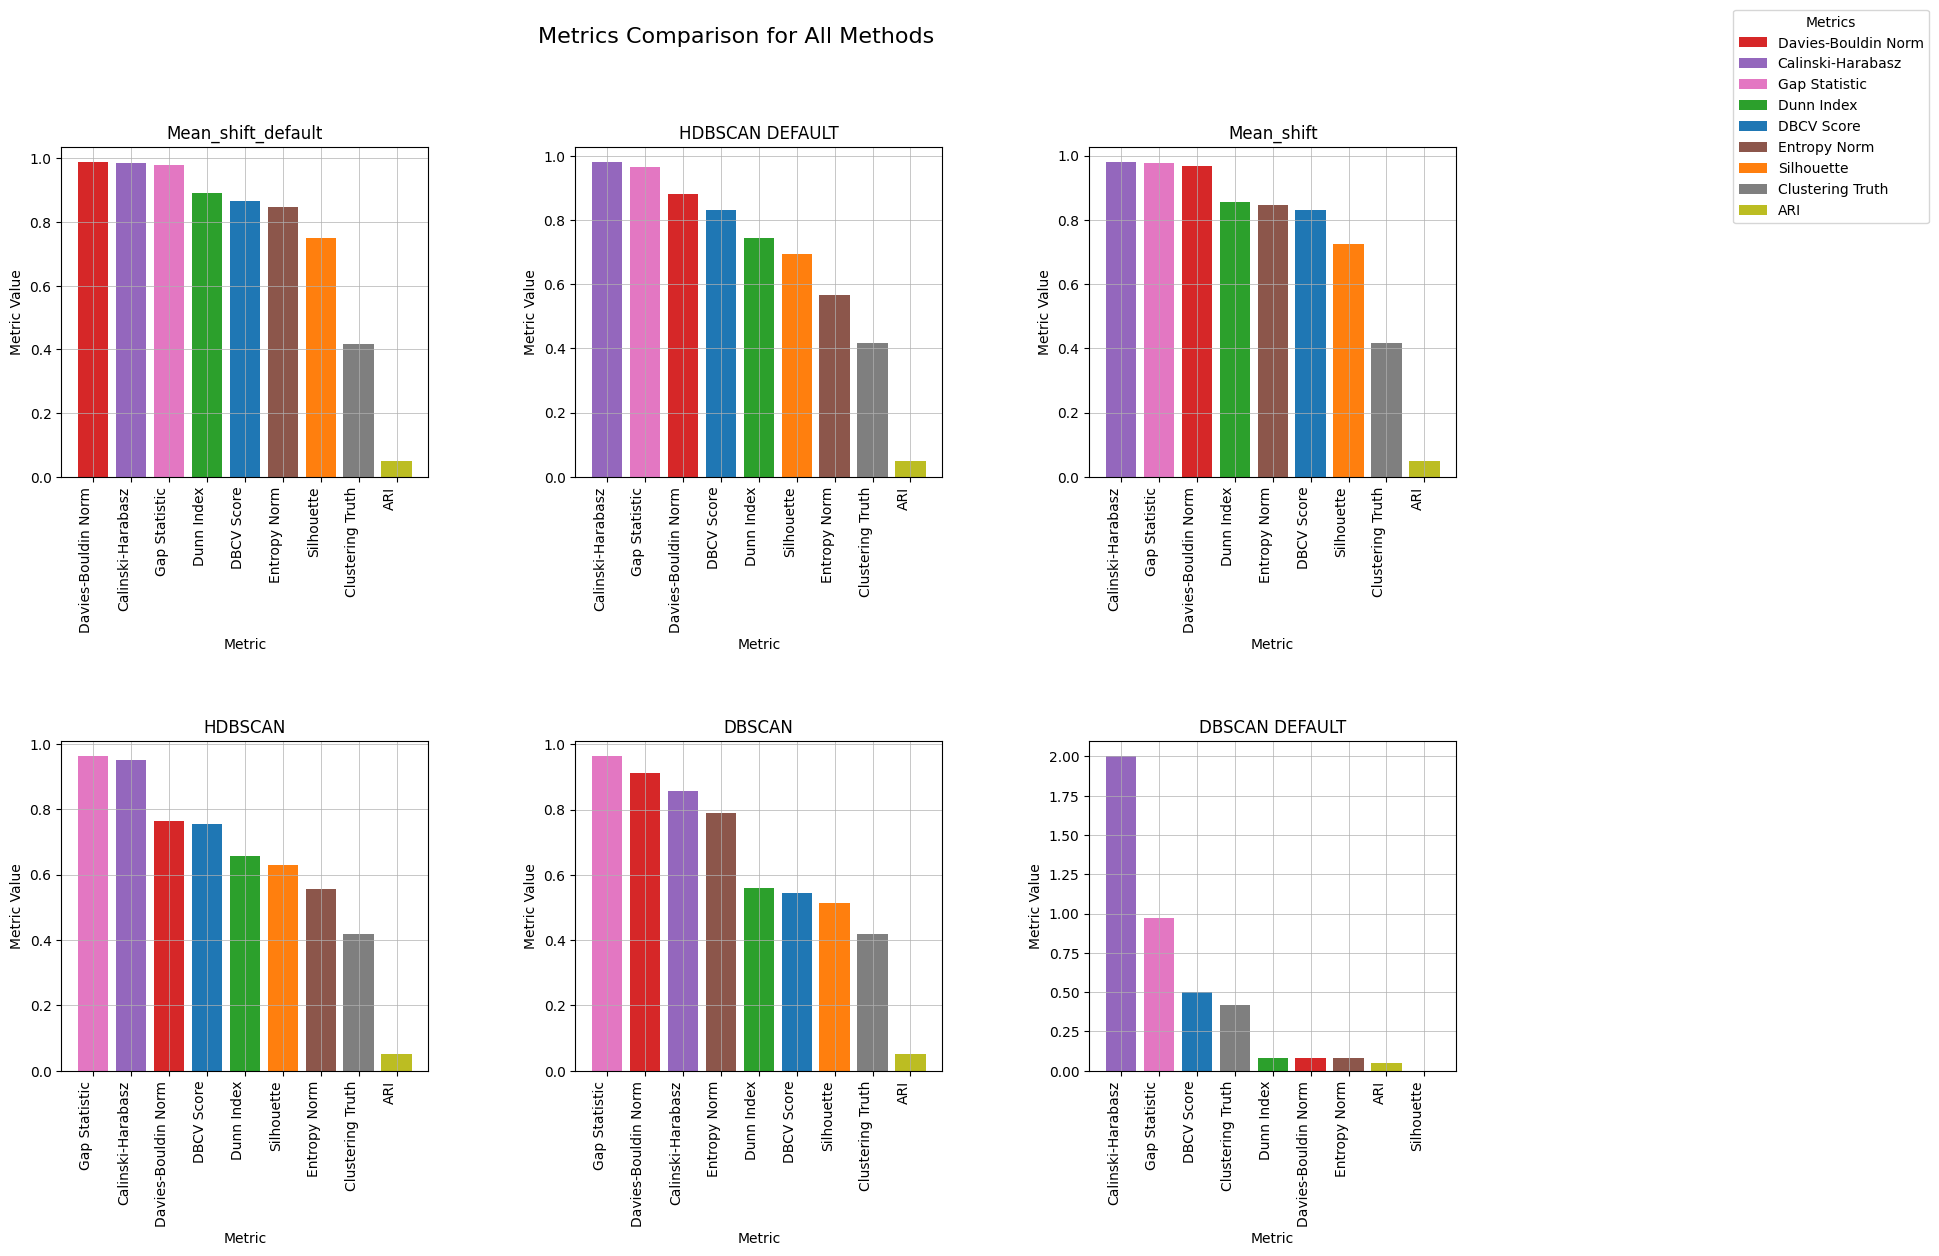

In [ ]:
df_metrics_diabetes.set_index("Method", inplace=True)

methods = df_metrics_diabetes.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_diabetes.columns)}
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for ax, method in zip(axes, methods):
    sorted_metrics = df_metrics_diabetes.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=90, ha='right')
    ax.grid(True, linewidth=0.5)

plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


#**Sepsis**

In [ ]:
sepsis = sepsis.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = sepsis.columns
scaler_minmax = MinMaxScaler()
sepsis_scaled = sepsis.copy()
sepsis_scaled[numerical_features] = scaler_minmax.fit_transform(sepsis_scaled[numerical_features])
sepsis_scaled.reset_index(drop=True, inplace=True)
sepsis_scaled.drop_duplicates(inplace=True)
df_metrics_sepsis = pd.DataFrame()
sepsis_scaled

Age  sex_woman  diagnosis_0EC_1M_2_AC  APACHE II    SOFA       CRP  \
0     0.061728        0.0                    1.0   0.291667  0.0000  0.000384   
1     0.432099        0.0                    1.0   0.208333  0.1875  0.172911   
2     0.802469        0.0                    1.0   0.166667  0.2500  0.228818   
3     0.209877        0.0                    1.0   0.062500  0.0000  0.141787   
4     0.839506        0.0                    1.0   0.354167  0.1250  0.095485   
...        ...        ...                    ...        ...     ...       ...   
1252  0.814815        1.0                    0.5   0.375000  0.1875  0.005764   
1253  0.148148        1.0                    0.5   0.062500  0.0000  0.001921   
1254  0.543210        1.0                    0.5   0.395833  0.3750  0.086455   
1255  0.160494        1.0                    0.5   0.333333  0.3125  0.038425   
1256  0.395062        0.0                    0.5   0.104167  0.0625  0.125456   

          WBCC      NeuC      LymC       EOC      NLCR      PLTC       MPV  \
0     0.195721  0.168191  0.174444  0.097561  0.015703  0.195730  0.093458   
1     0.367670  0.319682  0.088299  0.000000  0.061385  0.319098  0.100935   
2     0.237718  0.193042  0.102656  0.000000  0.031644  0.103203  0.085981   
3     0.140650  0.114712  0.134243  0.048780  0.014038  0.288256  0.073832   
4     0.198891  0.189463  0.111271  0.000000  0.028551  0.144721  0.110280   
...        ...       ...       ...       ...       ...       ...       ...   
1252  0.121038  0.100596  0.115578  0.073171  0.014276  0.158956  0.090654   
1253  0.144414  0.064215  0.497487  0.073171  0.001190  0.304864  0.096262   
1254  0.077060  0.066203  0.043790  0.048780  0.025934  0.209964  0.080374   
1255  0.154517  0.129026  0.108399  0.048780  0.019748  0.181495  0.084112   
1256  0.217512  0.192247  0.128500  0.000000  0.024982  0.213523  0.089720   

      Group   LOS-ICU  Mortality  
0       0.0  0.000000        0.0  
1       0.0  0.000000        0.0  
2       0.0  0.000000        0.0  
3       0.0  0.000000        0.0  
4       0.0  0.000000        0.0  
...     ...       ...        ...  
1252    0.0  0.052632        0.0  
1253    0.0  0.000000        0.0  
1254    0.0  0.147368        0.0  
1255    1.0  0.031579        0.0  
1256    0.0  0.000000        0.0  

[1257 rows x 16 columns]

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(sepsis_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(sepsis_scaled)
labels_default = hdbscan_cluster_default.fit_predict(sepsis_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels)
sepsis_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN DEFAULT'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels_default)
sepsis_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)


min_cluster_size: 6, cluster_selection_epsilon: 0.05


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(sepsis_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(sepsis_scaled)
labels_default = dbscan_default.fit_predict(sepsis_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels)
sepsis_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN DEFAULT'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels_default)
sepsis_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [ ]:
band = best_params_mean_shift(sepsis_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(sepsis_scaled)
labels_default = mean_shift_default.fit_predict(sepsis_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels)
sepsis_scaled['Mean_shift_pred'] = labels

methods = 'Mean_shift'
methods_default = 'Mean_shift_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels_default)
sepsis_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)
df_metrics_sepsis

Best bandwidth: 3.032


Method  DBCV Score  Silhouette  Dunn Index  \
0             HDBSCAN        0.40        0.31    0.096830   
1     HDBSCAN DEFAULT        0.35        0.46    0.025004   
2              DBSCAN        0.82        0.58    0.039535   
3      DBSCAN DEFAULT        0.89        0.81    0.013057   
4          Mean_shift        0.90        0.85    0.377478   
5  Mean_shift_default       -0.55        0.57    0.231504   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  
0                 0.64             286.31          0.59           1.84  
1                 0.76             816.52          0.61           1.80  
2                 0.92            1762.81          0.80           1.70  
3                 2.52            1772.17          0.57           1.20  
4                 3.84            9417.62          1.00           1.29  
5                 1.68             804.23          0.89           1.12

**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(sepsis_scaled)
cluster_similarity

[14 12  6 13 17 11  0  9  1 10  3  2  7 20 16 18  4  8 15  5 19]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 14 13 15]
[-1  5  2  6  4  0 10 11  8  3  9 12  1  7]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
1490           0       3       10    25.934765
1996           1       5        8    16.070008
2755           2       8       12    11.296738
2502           3       7        9     8.353222
4003           4      12        7     7.398568
...          ...     ...      ...          ...
1671           9      -1        0     0.000000
1670           9      -1        4     0.000000
1669           9      -1        6     0.000000
1668           9      -1        2     0.000000
4997          19      15        7     0.000000

[4998 rows x 4 columns]

In [ ]:
sepsis_scaled["DBSCAN_pred"] = sepsis_scaled["DBSCAN_pred"].astype(object)
sepsis_scaled["HDBSCAN_pred"] = sepsis_scaled["HDBSCAN_pred"].astype(object)
sepsis_scaled["Mean_shift_pred"] = sepsis_scaled["Mean_shift_pred"].astype(object)

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 3, "DBSCAN_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 10, "HDBSCAN_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 5, "DBSCAN_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 8, "HDBSCAN_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 12, "HDBSCAN_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'C'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 7, "DBSCAN_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 9, "HDBSCAN_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'D'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 12, "DBSCAN_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 7, "HDBSCAN_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'E'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 15, "DBSCAN_pred"] = 'F'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'F'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'F'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'G'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'G'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'G'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 10, "DBSCAN_pred"] = 'H'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'H'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'H'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 14, "DBSCAN_pred"] = 'I'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'I'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'I'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 6, "DBSCAN_pred"] = 'J'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'J'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 9, "Mean_shift_pred"] = 'J'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'K'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 5, "HDBSCAN_pred"] = 'K'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 11, "Mean_shift_pred"] = 'K'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'L'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 3, "HDBSCAN_pred"] = 'L'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 14, "Mean_shift_pred"] = 'L'

sepsis_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    sepsis_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,
              'J': 9,'K': 10,'L': 11,})
    .astype(int)
)

same_value_count = (sepsis_scaled["HDBSCAN_pred"] == sepsis_scaled["DBSCAN_pred"]) & \
                   (sepsis_scaled["DBSCAN_pred"] == sepsis_scaled["Mean_shift_pred"])

total_same_value = same_value_count.sum()
total_rows = len(sepsis_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(sepsis_scaled)
df_metrics_sepsis['Clustering Truth'] = percentage_same_value
df_metrics_sepsis['ARI'] = ari
df_metrics_sepsis = df_metrics_sepsis.sort_values('DBCV Score', ascending=False)
df_metrics_sepsis

Totale delle righe con lo stesso valore: 1084
Percentuale rispetto al totale: 86.24 %


Method  DBCV Score  Silhouette  Dunn Index  \
4          Mean_shift        0.90        0.85    0.377478   
3      DBSCAN DEFAULT        0.89        0.81    0.013057   
2              DBSCAN        0.82        0.58    0.039535   
0             HDBSCAN        0.40        0.31    0.096830   
1     HDBSCAN DEFAULT        0.35        0.46    0.025004   
5  Mean_shift_default       -0.55        0.57    0.231504   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
4                 3.84            9417.62          1.00           1.29   
3                 2.52            1772.17          0.57           1.20   
2                 0.92            1762.81          0.80           1.70   
0                 0.64             286.31          0.59           1.84   
1                 0.76             816.52          0.61           1.80   
5                 1.68             804.23          0.89           1.12   

   Clustering Truth      ARI  
4             0.862  0.29584  
3             0.862  0.29584  
2             0.862  0.29584  
0             0.862  0.29584  
1             0.862  0.29584  
5             0.862  0.29584

In [ ]:
df_metrics_sepsis["Silhouette"] = (df_metrics_sepsis["Silhouette"] + 1) / 2
df_metrics_sepsis["DBCV Score"] = (df_metrics_sepsis["DBCV Score"] + 1) / 2
df_metrics_sepsis["Dunn Index"] = (erf(df_metrics_sepsis["Dunn Index"]) + 1) / 2
df_metrics_sepsis["Davies-Bouldin Norm"] = (erf(df_metrics_sepsis["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_sepsis["Calinski-Harabasz"] = 1 - (1 / df_metrics_sepsis["Calinski-Harabasz"])
df_metrics_sepsis["Entropy Norm"] = (erf(df_metrics_sepsis["Entropy Norm"]) + 1) / 2
df_metrics_sepsis["Gap Statistic"] = (erf(df_metrics_sepsis["Gap Statistic"]) + 1) / 2
df_metrics_sepsis

Method  DBCV Score  Silhouette  Dunn Index  \
4          Mean_shift       0.950       0.925    0.703272   
3      DBSCAN DEFAULT       0.945       0.905    0.507366   
2              DBSCAN       0.910       0.790    0.522293   
0             HDBSCAN       0.700       0.655    0.554460   
1     HDBSCAN DEFAULT       0.675       0.730    0.514104   
5  Mean_shift_default       0.225       0.785    0.628316   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
4             1.000000           0.999894      0.921350       0.965949   
3             0.999817           0.999436      0.789908       0.955157   
2             0.903384           0.999433      0.871050       0.991895   
0             0.817293           0.996507      0.797968       0.995368   
1             0.858768           0.998775      0.805841       0.994545   
5             0.991246           0.998757      0.895922       0.943394   

   Clustering Truth      ARI  
4             0.862  0.29584  
3             0.862  0.29584  
2             0.862  0.29584  
0             0.862  0.29584  
1             0.862  0.29584  
5             0.862  0.29584

In [ ]:
distance_table_sepsis = df_metrics_sepsis.copy()

for metric in metrics:
    distance_table_sepsis[metric] = np.sqrt((df_metrics_sepsis[metric] - df_metrics_sepsis["Clustering Truth"]) ** 2)
distance_table_sepsis = distance_table_sepsis.sort_values(by="DBCV Score", ascending=True)
distance_table_sepsis.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_sepsis.columns
]
distance_table_sepsis

Method  DBCV Score Distance  Silhouette Distance  \
2              DBSCAN                0.048                0.072   
3      DBSCAN DEFAULT                0.083                0.043   
4          Mean_shift                0.088                0.063   
0             HDBSCAN                0.162                0.207   
1     HDBSCAN DEFAULT                0.187                0.132   
5  Mean_shift_default                0.637                0.077   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
2             0.339707                      0.041384   
3             0.354634                      0.137817   
4             0.158728                      0.138000   
0             0.307540                      0.044707   
1             0.347896                      0.003232   
5             0.233684                      0.129246   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
2                    0.137433               0.009050                0.129895   
3                    0.137436               0.072092                0.093157   
4                    0.137894               0.059350                0.103949   
0                    0.134507               0.064032                0.133368   
1                    0.136775               0.056159                0.132545   
5                    0.136757               0.033922                0.081394   

   Clustering Truth      ARI  
2             0.862  0.29584  
3             0.862  0.29584  
4             0.862  0.29584  
0             0.862  0.29584  
1             0.862  0.29584  
5             0.862  0.29584

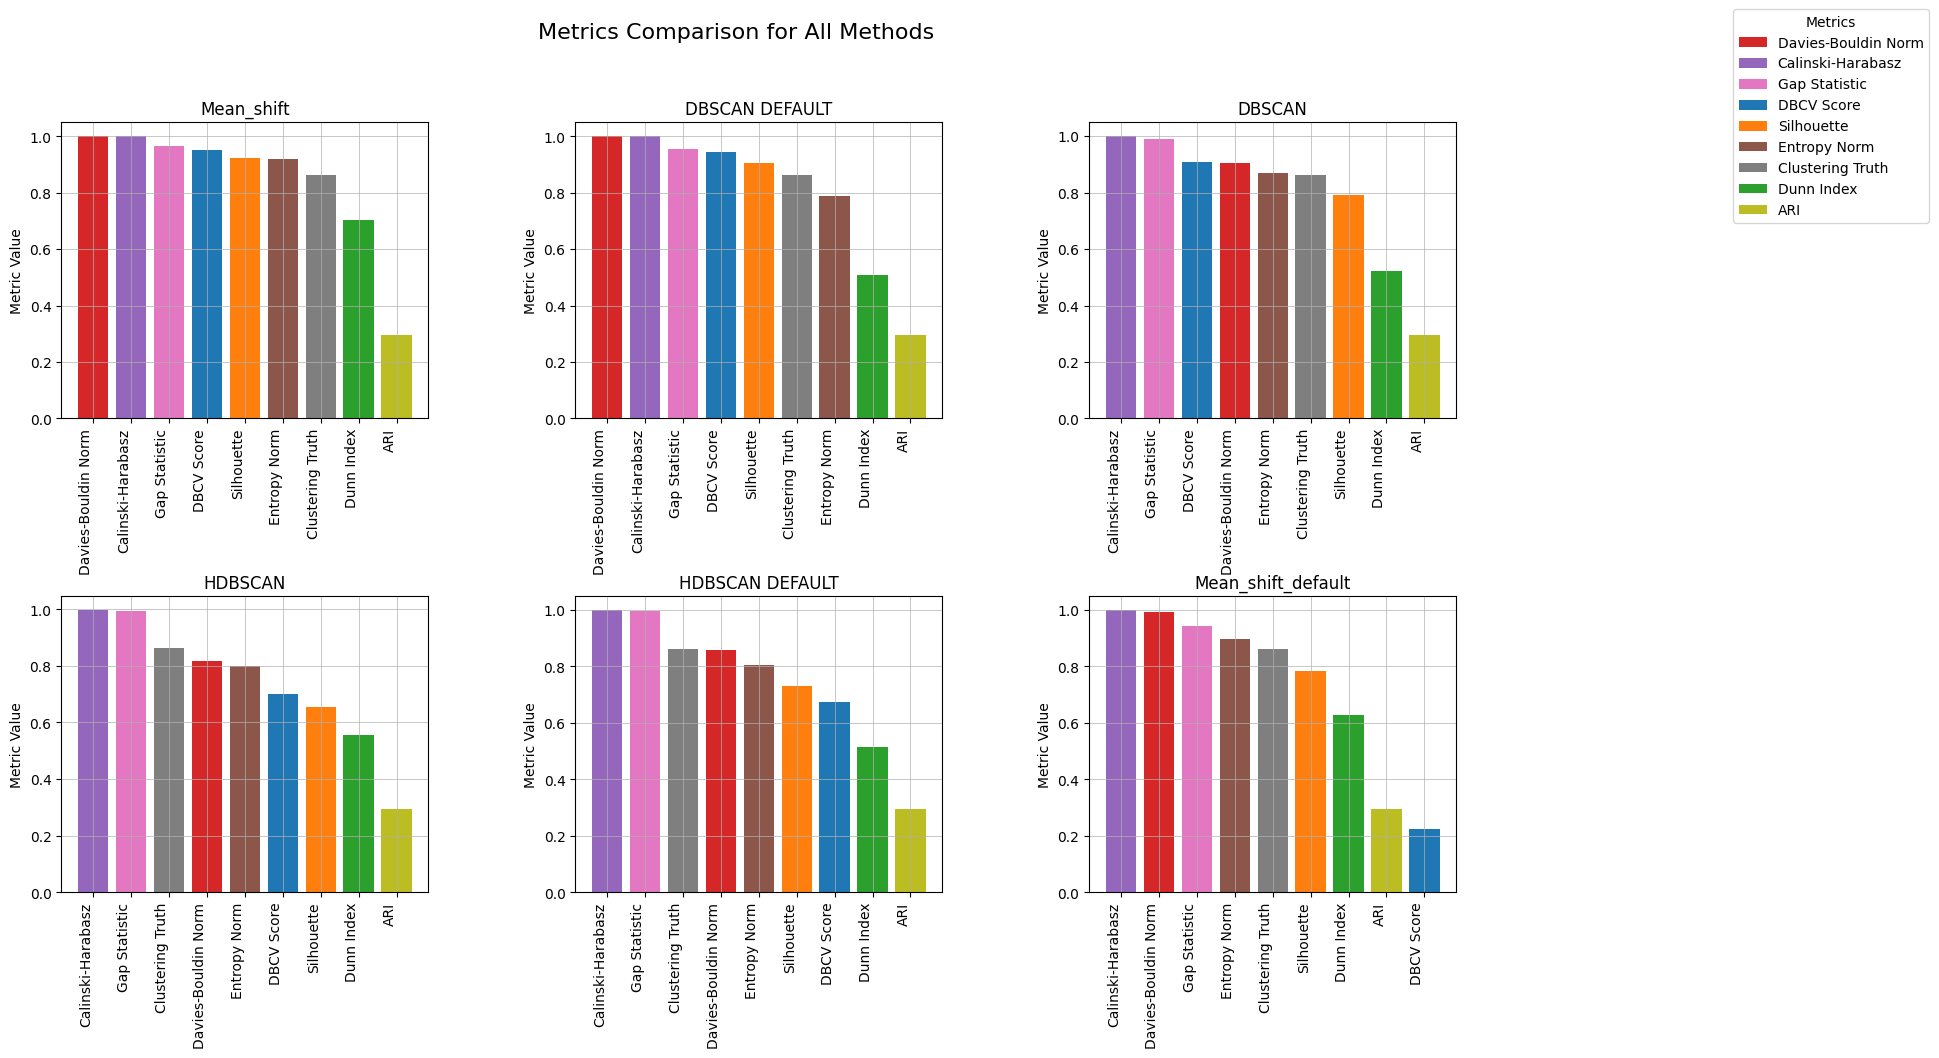

In [ ]:
df_metrics_sepsis.set_index("Method", inplace=True)

methods = df_metrics_sepsis.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_sepsis.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, methods):
    sorted_metrics = df_metrics_sepsis.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=90, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

plt.show()


#**Heart failure**

In [ ]:
heart_failure = heart_failure.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = heart_failure.columns
scaler_minmax = MinMaxScaler()
heart_failure_scaled = heart_failure.copy()
heart_failure_scaled[numerical_features] = scaler_minmax.fit_transform(heart_failure_scaled[numerical_features])
heart_failure_scaled.reset_index(drop=True, inplace=True)
heart_failure_scaled.drop_duplicates(inplace=True)
df_metrics_heart_failure = pd.DataFrame()
heart_failure_scaled

Age (years)  Male (1=Yes, 0=No)  PHQ-9  Systolic BP (mm Hg)  \
0       0.923077                 0.0   0.04             0.540000   
1       1.000000                 1.0   0.32             0.340000   
2       0.794872                 1.0   0.16             0.380000   
3       0.833333                 1.0   0.16             0.326667   
4       0.807692                 1.0   0.12             0.520000   
..           ...                 ...    ...                  ...   
420     0.371795                 1.0   0.12             0.526667   
421     0.666667                 1.0   0.44             0.606667   
422     0.538462                 1.0   0.68             0.473333   
423     0.346154                 1.0   0.16             0.720000   
424     0.423077                 0.0   1.00             0.466667   

     Estimated glomerular filtration rate  Ejection fraction (%)  \
0                                0.253775               0.695035   
1                                0.169680               0.758865   
2                                0.325089               0.758865   
3                                0.360210               0.297872   
4                                0.324216               0.659574   
..                                    ...                    ...   
420                              0.457364               0.539007   
421                              0.148905               0.659574   
422                              0.673790               0.225532   
423                              0.331913               0.075603   
424                              0.218280               0.617021   

     Serum sodium (mmol/l)  Blood urea nitrogen (mg/dl)  \
0                 0.500000                     0.218487   
1                 0.636364                     0.630252   
2                 0.681818                     0.235294   
3                 0.681818                     0.394958   
4                 0.500000                     0.268908   
..                     ...                          ...   
420               0.500000                     0.226891   
421               0.590909                     0.352941   
422               0.181818                     0.142857   
423               0.636364                     0.285714   
424               0.681818                     0.647059   

     Etiology HF(1=Yes, 0=No)  Prior diabetes mellitus  \
0                         1.0                      1.0   
1                         1.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      1.0   
4                         0.0                      1.0   
..                        ...                      ...   
420                       1.0                      1.0   
421                       0.0                      0.0   
422                       0.0                      1.0   
423                       0.0                      0.0   
424                       0.0                      1.0   

     Elevated level of BNP/NT-BNP (1=Yes, 0=No)  Time from HF to Death (days)  \
0                                           1.0                      0.929655   
1                                           1.0                      0.095172   
2                                           1.0                      1.000000   
3                                           1.0                      1.000000   
4                                           1.0                      1.000000   
..                                          ...                           ...   
420                                         1.0                      1.000000   
421                                         1.0                      1.000000   
422                                         1.0                      0.459310   
423                                         1.0                      1.000000   
424                                         1.0                      0.950

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(heart_failure_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(heart_failure_scaled)
labels_default = hdbscan_cluster_default.fit_predict(heart_failure_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels)
heart_failure_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN DEFAULT'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels_default)
heart_failure_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)

min_cluster_size: 5, cluster_selection_epsilon: 0.05


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(heart_failure_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(heart_failure_scaled)
labels_default = dbscan_default.fit_predict(heart_failure_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels)
heart_failure_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN DEFAULT'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels_default)
heart_failure_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [ ]:
band = best_params_mean_shift(heart_failure_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(heart_failure_scaled)
labels_default = mean_shift_default.fit_predict(heart_failure_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels)
heart_failure_scaled['Mean_shift_pred'] = labels

methods = 'Mean_shift'
methods_default = 'Mean_shift_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels_default)
heart_failure_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)
df_metrics_heart_failure

Banda 16.138146103690083 genera solo un cluster. Ignorato.
Best bandwidth: 5.379


Method  DBCV Score  Silhouette  Dunn Index  \
0             HDBSCAN        0.56        0.27    0.163598   
1     HDBSCAN DEFAULT        0.68        0.48    0.372858   
2              DBSCAN        0.59        0.16    0.014308   
3      DBSCAN DEFAULT        0.52        0.17    0.007831   
4          Mean_shift        0.15        0.69    0.048234   
5  Mean_shift_default       -0.79        0.42    0.059342   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  
0                 0.75              31.11          0.43           0.48  
1                 1.51            1790.27          0.43           0.26  
2                 0.61              42.09          1.00           0.16  
3                 0.69              27.93          1.18          -1.50  
4                 2.75             793.92          0.83          -1.97  
5                 1.12             270.34          0.25          -2.14

**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(heart_failure_scaled)
cluster_similarity

[ 0  1  2 14  4 13 22  8  7 24 19  5 12 11 10 23 20  3 16  6  9 17 15 21
 18 26 25 27]
[-1  0  1  2  3  4  5  6 17  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22
 23 24 26 25 30 27 28 29 31]
[-1 14  6  1  3 15 23 12 17 21  5 10 13  2 18 24  4  9 19  8  0 16 22 20
  7 11]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
0               0      -1       -1    16.235294
885             1       0       14     7.058824
3567            4       4       15     5.647059
16869           6      20       16     4.941176
7135            7       8       10     4.235294
...           ...     ...      ...          ...
8024           24       9        4     0.000000
8023           24       9       24     0.000000
8022           24       9       18     0.000000
8021           24       9        2     0.000000
24023          27      31       11     0.000000

[24024 rows x 4 columns]

In [ ]:
heart_failure_scaled["DBSCAN_pred"] = heart_failure_scaled["DBSCAN_pred"].astype(object)
heart_failure_scaled["HDBSCAN_pred"] = heart_failure_scaled["HDBSCAN_pred"].astype(object)
heart_failure_scaled["Mean_shift_pred"] = heart_failure_scaled["Mean_shift_pred"].astype(object)

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 14, "HDBSCAN_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 4, "DBSCAN_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 15, "HDBSCAN_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'C'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 16, "DBSCAN_pred"] = 'D'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 16, "HDBSCAN_pred"] = 'D'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'D'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'E'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 10, "HDBSCAN_pred"] = 'E'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'E'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 14, "DBSCAN_pred"] = 'F'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 19, "HDBSCAN_pred"] = 'F'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'F'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'G'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 9, "HDBSCAN_pred"] = 'G'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 10, "Mean_shift_pred"] = 'G'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 18, "DBSCAN_pred"] = 'H'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 24, "HDBSCAN_pred"] = 'H'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'H'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 7, "DBSCAN_pred"] = 'I'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 5, "HDBSCAN_pred"] = 'I'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'I'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 1, "DBSCAN_pred"] = 'J'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 6, "HDBSCAN_pred"] = 'J'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'J'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 12, "DBSCAN_pred"] = 'K'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'K'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 11, "Mean_shift_pred"] = 'K'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 17, "DBSCAN_pred"] = 'L'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 21, "HDBSCAN_pred"] = 'L'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'L'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 11, "DBSCAN_pred"] = 'M'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 18, "HDBSCAN_pred"] = 'M'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'M'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 5, "DBSCAN_pred"] = 'N'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 23, "HDBSCAN_pred"] = 'N'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 13, "Mean_shift_pred"] = 'N'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 26, "DBSCAN_pred"] = 'O'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 20, "HDBSCAN_pred"] = 'O'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 15, "Mean_shift_pred"] = 'O'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 3, "DBSCAN_pred"] = 'P'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 3, "HDBSCAN_pred"] = 'P'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 14, "Mean_shift_pred"] = 'P'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 19, "DBSCAN_pred"] = 'Q'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 8, "HDBSCAN_pred"] = 'Q'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 16, "Mean_shift_pred"] = 'Q'


heart_failure_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    heart_failure_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,
              'J': 9,'K': 10,'L': 11,'M': 12,'N': 13,'O': 14,'P': 15,'Q':16})
    .astype(int)
)

same_value_count = (heart_failure_scaled["HDBSCAN_pred"] == heart_failure_scaled["DBSCAN_pred"]) & \
                   (heart_failure_scaled["DBSCAN_pred"] == heart_failure_scaled["Mean_shift_pred"])

total_same_value = same_value_count.sum()
total_rows = len(heart_failure_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(heart_failure_scaled)
df_metrics_heart_failure['Clustering Truth'] = percentage_same_value
df_metrics_heart_failure['ARI'] = ari
df_metrics_heart_failure = df_metrics_heart_failure.sort_values('DBCV Score', ascending=False)
df_metrics_heart_failure

Totale delle righe con lo stesso valore: 250
Percentuale rispetto al totale: 58.82 %


Method  DBCV Score  Silhouette  Dunn Index  \
1     HDBSCAN DEFAULT        0.68        0.48    0.372858   
2              DBSCAN        0.59        0.16    0.014308   
0             HDBSCAN        0.56        0.27    0.163598   
3      DBSCAN DEFAULT        0.52        0.17    0.007831   
4          Mean_shift        0.15        0.69    0.048234   
5  Mean_shift_default       -0.79        0.42    0.059342   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
1                 1.51            1790.27          0.43           0.26   
2                 0.61              42.09          1.00           0.16   
0                 0.75              31.11          0.43           0.48   
3                 0.69              27.93          1.18          -1.50   
4                 2.75             793.92          0.83          -1.97   
5                 1.12             270.34          0.25          -2.14   

   Clustering Truth      ARI  
1             0.588  0.29584  
2             0.588  0.29584  
0             0.588  0.29584  
3             0.588  0.29584  
4             0.588  0.29584  
5             0.588  0.29584

In [ ]:
df_metrics_heart_failure["Silhouette"] = (df_metrics_heart_failure["Silhouette"] + 1) / 2
df_metrics_heart_failure["DBCV Score"] = (df_metrics_heart_failure["DBCV Score"] + 1) / 2
df_metrics_heart_failure["Dunn Index"] = (erf(df_metrics_heart_failure["Dunn Index"]) + 1) / 2
df_metrics_heart_failure["Davies-Bouldin Norm"] = (erf(df_metrics_heart_failure["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_heart_failure["Calinski-Harabasz"] = 1 - (1 / df_metrics_heart_failure["Calinski-Harabasz"])
df_metrics_heart_failure["Entropy Norm"] = (erf(df_metrics_heart_failure["Entropy Norm"]) + 1) / 2
df_metrics_heart_failure["Gap Statistic"] = (erf(df_metrics_heart_failure["Gap Statistic"]) + 1) / 2
df_metrics_heart_failure

Method  DBCV Score  Silhouette  Dunn Index  \
1     HDBSCAN DEFAULT       0.840       0.740    0.701007   
2              DBSCAN       0.795       0.580    0.508072   
0             HDBSCAN       0.780       0.635    0.591483   
3      DBSCAN DEFAULT       0.760       0.585    0.504418   
4          Mean_shift       0.575       0.845    0.527192   
5  Mean_shift_default       0.105       0.710    0.533441   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
1             0.983638           0.999441      0.728443       0.643450   
2             0.805841           0.976241      0.921350       0.589506   
0             0.855578           0.967856      0.728443       0.751375   
3             0.835420           0.964196      0.952419       0.016947   
4             0.999950           0.998740      0.879762       0.002668   
5             0.943394           0.996301      0.638163       0.001237   

   Clustering Truth      ARI  
1             0.588  0.29584  
2             0.588  0.29584  
0             0.588  0.29584  
3             0.588  0.29584  
4             0.588  0.29584  
5             0.588  0.29584

In [ ]:
distance_table_heart_failure = df_metrics_heart_failure.copy()

for metric in metrics:
    distance_table_heart_failure[metric] = np.sqrt((df_metrics_heart_failure[metric] - df_metrics_heart_failure["Clustering Truth"]) ** 2)
distance_table_heart_failure = distance_table_heart_failure.sort_values(by="DBCV Score", ascending=True)
distance_table_heart_failure.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_heart_failure.columns
]
distance_table_heart_failure

Method  DBCV Score Distance  Silhouette Distance  \
4          Mean_shift                0.013                0.257   
3      DBSCAN DEFAULT                0.172                0.003   
0             HDBSCAN                0.192                0.047   
2              DBSCAN                0.207                0.008   
1     HDBSCAN DEFAULT                0.252                0.152   
5  Mean_shift_default                0.483                0.122   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
4             0.060808                      0.411950   
3             0.083582                      0.247420   
0             0.003483                      0.267578   
2             0.079928                      0.217841   
1             0.113007                      0.395638   
5             0.054559                      0.355394   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
4                    0.410740               0.291762                0.585332   
3                    0.376196               0.364419                0.571053   
0                    0.379856               0.140443                0.163375   
2                    0.388241               0.333350                0.001506   
1                    0.411441               0.140443                0.055450   
5                    0.408301               0.050163                0.586763   

   Clustering Truth      ARI  
4             0.588  0.29584  
3             0.588  0.29584  
0             0.588  0.29584  
2             0.588  0.29584  
1             0.588  0.29584  
5             0.588  0.29584

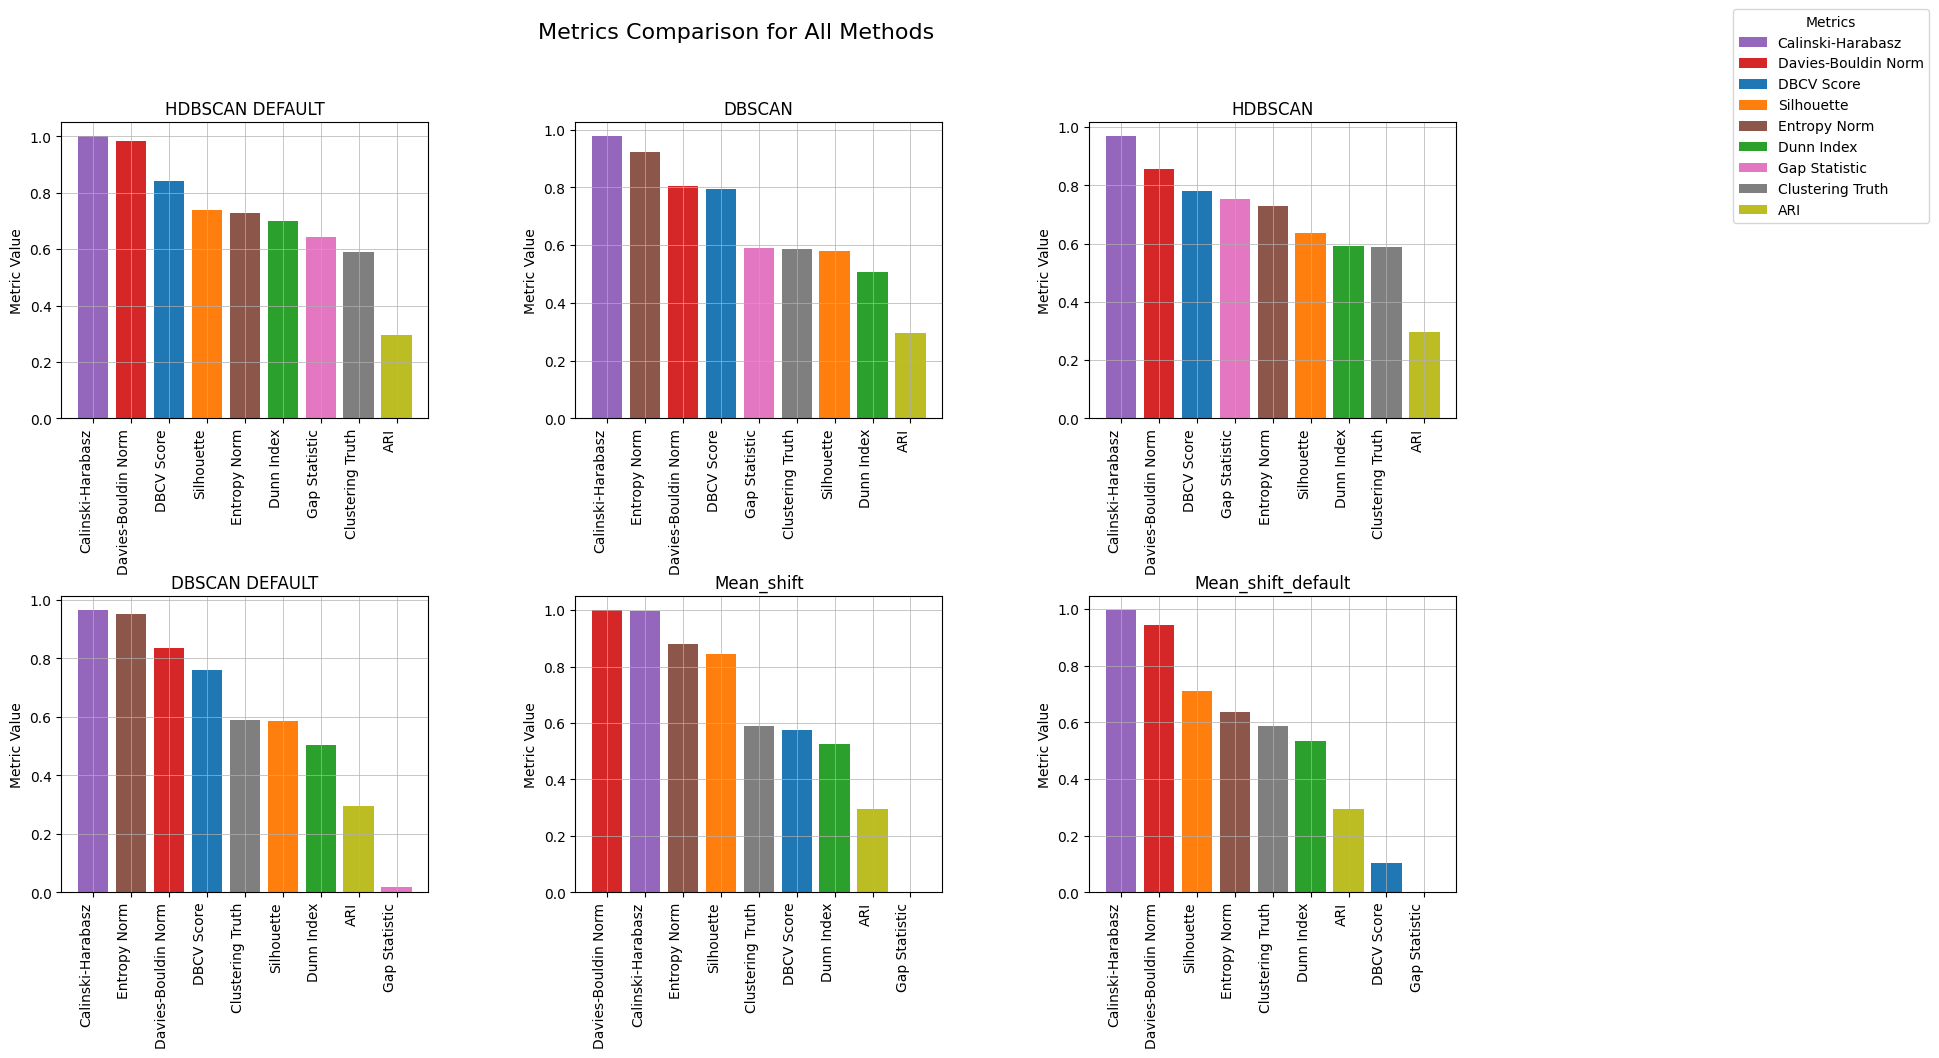

In [ ]:
df_metrics_heart_failure.set_index("Method", inplace=True)

methods = df_metrics_heart_failure.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_heart_failure.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, methods):
    sorted_metrics = df_metrics_heart_failure.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=90, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

plt.show()


#**Cardiac Arrest**

In [ ]:
cardiac_arrest = cardiac_arrest.fillna(0)
numerical_features = cardiac_arrest.columns
scaler_minmax = MinMaxScaler()
cardiac_arrest_scaled = cardiac_arrest.copy()
cardiac_arrest_scaled[numerical_features] = scaler_minmax.fit_transform(cardiac_arrest_scaled[numerical_features])
cardiac_arrest_scaled.reset_index(drop=True, inplace=True)
cardiac_arrest_scaled.drop_duplicates(inplace=True)
df_metrics_cardiac_arrest = pd.DataFrame()
cardiac_arrest_scaled

Exitus  sex_woman  Age_years  Endotracheal_intubation  Functional_status  \
0       1.0        0.0   0.340206                      1.0           1.000000   
1       1.0        1.0   0.402062                      1.0           1.000000   
2       1.0        0.0   0.505155                      1.0           1.000000   
3       0.0        0.0   0.505155                      1.0           1.000000   
4       1.0        0.0   0.515464                      1.0           1.000000   
..      ...        ...        ...                      ...                ...   
417     1.0        0.0   0.742268                      1.0           1.000000   
418     1.0        0.0   0.649485                      1.0           1.000000   
419     1.0        0.0   0.711340                      1.0           0.666667   
420     1.0        0.0   0.670103                      1.0           1.000000   
421     1.0        0.0   0.536082                      1.0           1.000000   

     Asystole  Cardiac_arrest_at_home  Bystander  Time_min  Cardiogenic  
0         1.0                     1.0        1.0  0.102041          1.0  
1         1.0                     1.0        1.0  0.204082          1.0  
2         0.0                     0.0        1.0  0.469388          0.0  
3         0.0                     1.0        1.0  0.142857          1.0  
4         0.0                     0.0        1.0  0.306122          1.0  
..        ...                     ...        ...       ...          ...  
417       0.0                     1.0        1.0  0.183673          1.0  
418       1.0                     1.0        1.0  0.387755          1.0  
419       1.0                     0.0        0.0  0.183673          1.0  
420       0.0                     1.0        0.0  0.306122          0.0  
421       1.0                     1.0        0.0  0.102041          0.0  

[420 rows x 10 columns]

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(cardiac_arrest_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(cardiac_arrest_scaled)
labels_default = hdbscan_cluster_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels)
cardiac_arrest_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN DEFAULT'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels_default)
cardiac_arrest_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])

df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)


min_cluster_size: 5, cluster_selection_epsilon: 0.05


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(cardiac_arrest_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(cardiac_arrest_scaled)
labels_default = dbscan_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels)
cardiac_arrest_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN DEFAULT'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels_default)
cardiac_arrest_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)
df_metrics_cardiac_arrest

min_cluster_size: 3, cluster_selection_epsilon: 0.5


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0          HDBSCAN        0.61        0.36    0.021759                 0.78   
1  HDBSCAN DEFAULT        0.67        0.58    0.476329                 2.69   
2           DBSCAN        0.80        0.58    0.014646                 1.08   
3   DBSCAN DEFAULT        0.70        0.50    0.035331                 0.58   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              23.14          0.67          -0.04  
1            2199.53          0.67          -0.41  
2             316.20          0.56          -0.40  
3              35.68          0.70          -1.83

**Mean_Shift**

In [ ]:
band = best_params_mean_shift(cardiac_arrest_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(cardiac_arrest_scaled)
labels_default = mean_shift_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels)
cardiac_arrest_scaled['Mean_shift_pred'] = labels

methods = 'Mean_shift'
methods_default = 'Mean_shift_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels_default)
cardiac_arrest_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)
df_metrics_cardiac_arrest

Banda 24.321039997788574 genera solo un cluster. Ignorato.
Best bandwidth: 8.107


Method  DBCV Score  Silhouette  Dunn Index  \
0             HDBSCAN        0.61        0.36    0.021759   
1     HDBSCAN DEFAULT        0.67        0.58    0.476329   
2              DBSCAN        0.80        0.58    0.014646   
3      DBSCAN DEFAULT        0.70        0.50    0.035331   
4          Mean_shift        0.43        0.67    0.363045   
5  Mean_shift_default       -0.88        0.37    0.102755   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  
0                 0.78              23.14          0.67          -0.04  
1                 2.69            2199.53          0.67          -0.41  
2                 1.08             316.20          0.56          -0.40  
3                 0.58              35.68          0.70          -1.83  
4                 2.22             994.65          0.35          -2.00  
5                 0.90             187.06          0.24          -1.80

**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(cardiac_arrest_scaled)
cluster_similarity

[ 2  0  1 10  8  4  3  7  6  5  9]
[ 0  1  2 -1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 41 36 37 38 39 40 42]
[23 22  7 -1 12 18 14 15 11 13 17 24  3  4  9  8 25 21  6 19 20 10  1  2
  5  0 16]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
2460            1      -1       -1    15.000000
0               2       0       23     6.666667
7630            3      17       25     5.952381
1411            0       7       15     5.000000
1300            0       3       12     4.285714
...           ...     ...      ...          ...
4368           10      28       10     0.000000
4369           10      28        1     0.000000
4370           10      28        2     0.000000
4371           10      28        5     0.000000
13067           9      42       16     0.000000

[13068 rows x 4 columns]

In [ ]:
cardiac_arrest_scaled["DBSCAN_pred"] = cardiac_arrest_scaled["DBSCAN_pred"].astype(object)
cardiac_arrest_scaled["HDBSCAN_pred"] = cardiac_arrest_scaled["HDBSCAN_pred"].astype(object)
cardiac_arrest_scaled["Mean_shift_pred"] = cardiac_arrest_scaled["Mean_shift_pred"].astype(object)

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'A'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 23, "HDBSCAN_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'B'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 17, "DBSCAN_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 25, "HDBSCAN_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'C'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 7, "DBSCAN_pred"] = 'D'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 15, "HDBSCAN_pred"] = 'D'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'D'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'E'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 9, "HDBSCAN_pred"] = 'E'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 40, "Mean_shift_pred"] = 'E'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 32, "DBSCAN_pred"] = 'F'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 16, "HDBSCAN_pred"] = 'F'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 9, "Mean_shift_pred"] = 'F'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 22, "DBSCAN_pred"] = 'G'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 10, "HDBSCAN_pred"] = 'G'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'G'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 30, "DBSCAN_pred"] = 'H'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'H'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'H'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 12, "DBSCAN_pred"] = 'I'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'I'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'I'

cardiac_arrest_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    cardiac_arrest_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8,})
    .astype(int)
)

same_value_count = (cardiac_arrest_scaled["HDBSCAN_pred"] == cardiac_arrest_scaled["DBSCAN_pred"]) & \
                   (cardiac_arrest_scaled["DBSCAN_pred"] == cardiac_arrest_scaled["Mean_shift_pred"])

total_same_value = same_value_count.sum()
total_rows = len(cardiac_arrest_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(cardiac_arrest_scaled)
df_metrics_cardiac_arrest['Clustering Truth'] = percentage_same_value
df_metrics_cardiac_arrest['ARI'] = ari
df_metrics_cardiac_arrest = df_metrics_cardiac_arrest.sort_values('DBCV Score', ascending=False)
df_metrics_cardiac_arrest

Totale delle righe con lo stesso valore: 189
Percentuale rispetto al totale: 45.0 %


Method  DBCV Score  Silhouette  Dunn Index  \
2              DBSCAN        0.80        0.58    0.014646   
3      DBSCAN DEFAULT        0.70        0.50    0.035331   
1     HDBSCAN DEFAULT        0.67        0.58    0.476329   
0             HDBSCAN        0.61        0.36    0.021759   
4          Mean_shift        0.43        0.67    0.363045   
5  Mean_shift_default       -0.88        0.37    0.102755   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
2                 1.08             316.20          0.56          -0.40   
3                 0.58              35.68          0.70          -1.83   
1                 2.69            2199.53          0.67          -0.41   
0                 0.78              23.14          0.67          -0.04   
4                 2.22             994.65          0.35          -2.00   
5                 0.90             187.06          0.24          -1.80   

   Clustering Truth      ARI  
2              0.45  0.29584  
3              0.45  0.29584  
1              0.45  0.29584  
0              0.45  0.29584  
4              0.45  0.29584  
5              0.45  0.29584

In [ ]:
df_metrics_cardiac_arrest["Silhouette"] = (df_metrics_cardiac_arrest["Silhouette"] + 1) / 2
df_metrics_cardiac_arrest["DBCV Score"] = (df_metrics_cardiac_arrest["DBCV Score"] + 1) / 2
df_metrics_cardiac_arrest["Dunn Index"] = (erf(df_metrics_cardiac_arrest["Dunn Index"]) + 1) / 2
df_metrics_cardiac_arrest["Davies-Bouldin Norm"] = (erf(df_metrics_cardiac_arrest["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_cardiac_arrest["Calinski-Harabasz"] = 1 - (1 / df_metrics_cardiac_arrest["Calinski-Harabasz"])
df_metrics_cardiac_arrest["Entropy Norm"] = (erf(df_metrics_cardiac_arrest["Entropy Norm"]) + 1) / 2
df_metrics_cardiac_arrest["Gap Statistic"] = (erf(df_metrics_cardiac_arrest["Gap Statistic"]) + 1) / 2
df_metrics_cardiac_arrest

Method  DBCV Score  Silhouette  Dunn Index  \
2              DBSCAN       0.900       0.790    0.508262   
3      DBSCAN DEFAULT       0.850       0.750    0.519925   
1     HDBSCAN DEFAULT       0.835       0.790    0.749727   
0             HDBSCAN       0.805       0.680    0.512274   
4          Mean_shift       0.715       0.835    0.696173   
5  Mean_shift_default       0.060       0.685    0.557770   

   Davies-Bouldin Norm  Calinski-Harabasz  Entropy Norm  Gap Statistic  \
2             0.936663           0.996837      0.785808       0.285804   
3             0.793961           0.971973      0.838901       0.004827   
1             0.999929           0.999545      0.828314       0.281015   
0             0.865005           0.956785      0.828314       0.477444   
4             0.999154           0.998995      0.689691       0.002339   
5             0.898454           0.994654      0.632850       0.005455   

   Clustering Truth      ARI  
2              0.45  0.29584  
3              0.45  0.29584  
1              0.45  0.29584  
0              0.45  0.29584  
4              0.45  0.29584  
5              0.45  0.29584

In [ ]:
distance_table_cardiac_arrest = df_metrics_cardiac_arrest.copy()

for metric in metrics:
    distance_table_cardiac_arrest[metric] = np.sqrt((df_metrics_cardiac_arrest[metric] - df_metrics_cardiac_arrest["Clustering Truth"]) ** 2)
distance_table_cardiac_arrest = distance_table_cardiac_arrest.sort_values(by="DBCV Score", ascending=True)
distance_table_cardiac_arrest.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_cardiac_arrest.columns
]
distance_table_cardiac_arrest

Method  DBCV Score Distance  Silhouette Distance  \
4          Mean_shift                0.265                0.385   
0             HDBSCAN                0.355                0.230   
1     HDBSCAN DEFAULT                0.385                0.340   
5  Mean_shift_default                0.390                0.235   
3      DBSCAN DEFAULT                0.400                0.300   
2              DBSCAN                0.450                0.340   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
4             0.246173                      0.549154   
0             0.062274                      0.415005   
1             0.299727                      0.549929   
5             0.107770                      0.448454   
3             0.069925                      0.343961   
2             0.058262                      0.486663   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
4                    0.548995               0.239691                0.447661   
0                    0.506785               0.378314                0.027444   
1                    0.549545               0.378314                0.168985   
5                    0.544654               0.182850                0.444545   
3                    0.521973               0.388901                0.445173   
2                    0.546837               0.335808                0.164196   

   Clustering Truth      ARI  
4              0.45  0.29584  
0              0.45  0.29584  
1              0.45  0.29584  
5              0.45  0.29584  
3              0.45  0.29584  
2              0.45  0.29584

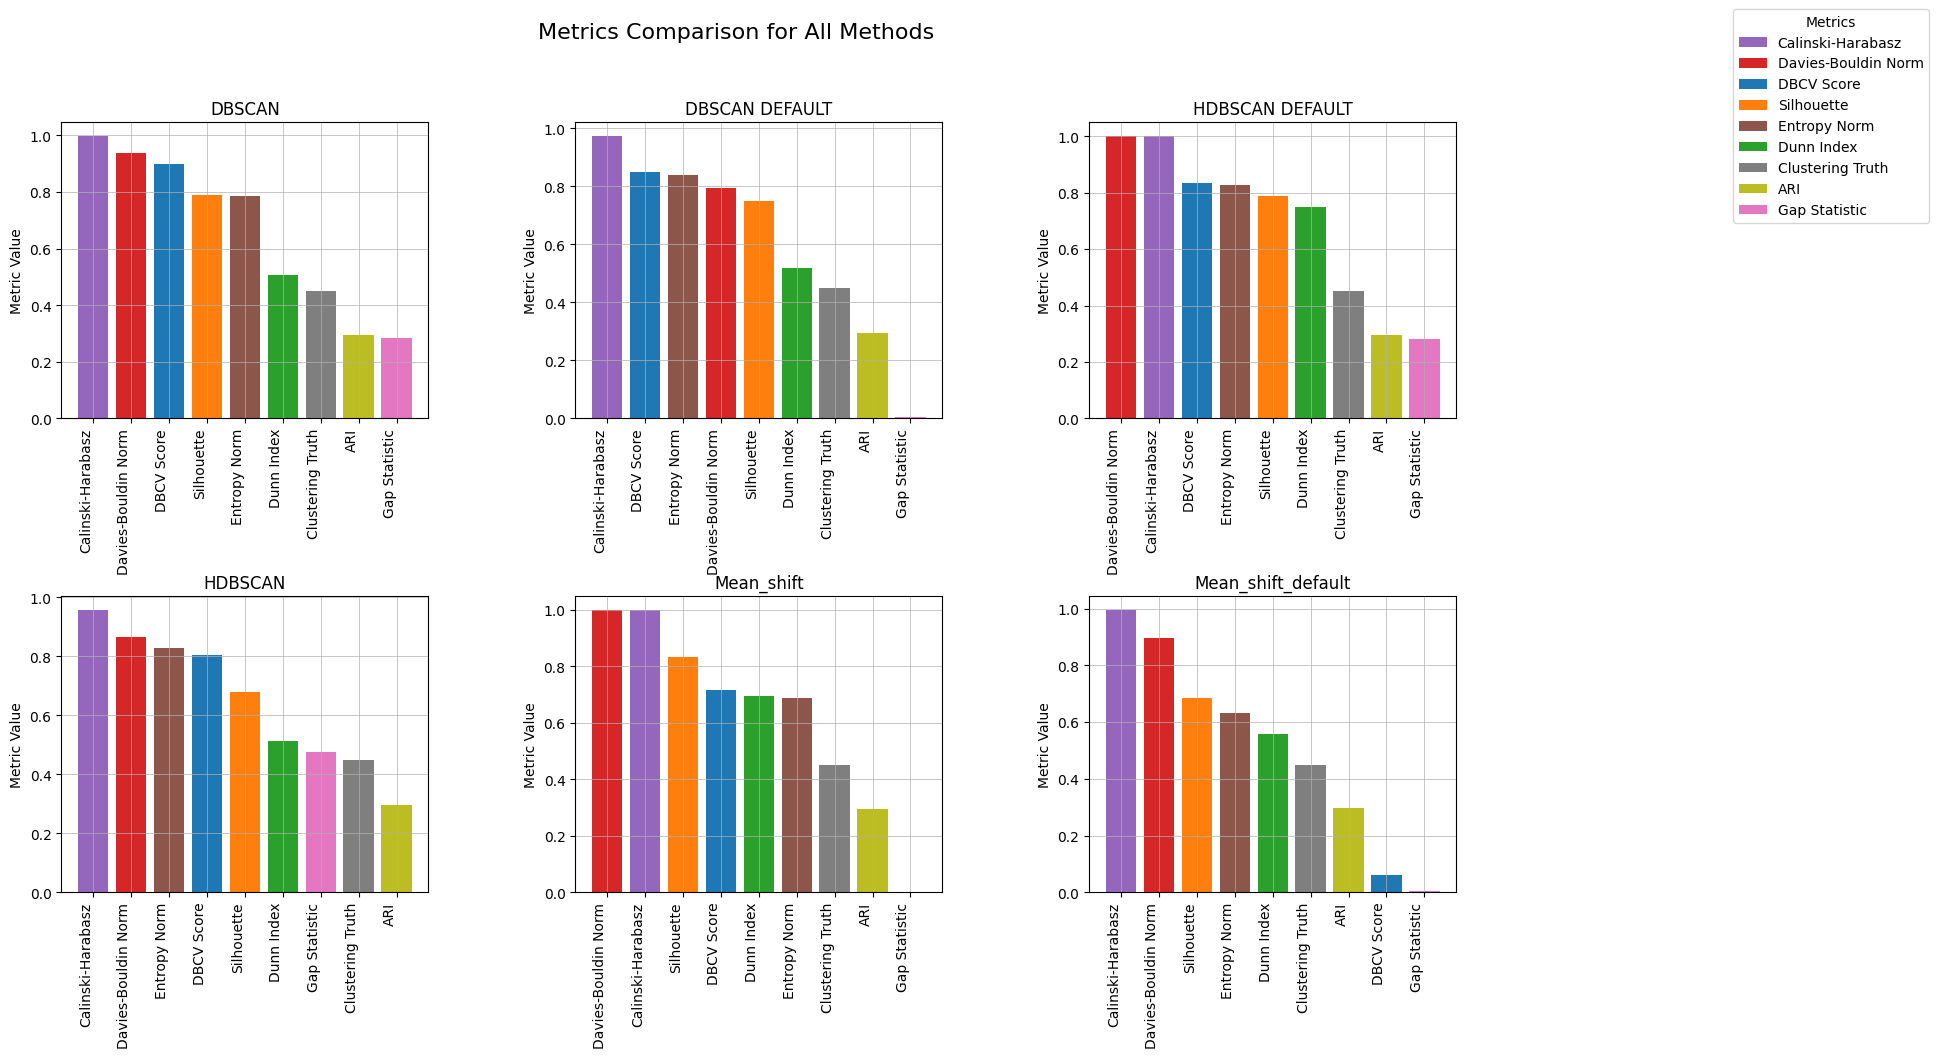

In [ ]:
df_metrics_cardiac_arrest.set_index("Method", inplace=True)

methods = df_metrics_cardiac_arrest.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_cardiac_arrest.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, methods):
    sorted_metrics = df_metrics_cardiac_arrest.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=90, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for All Methods', fontsize=16)

plt.show()
